In [1]:
import pandas as pd
# Pandas: Library for data manipulation and analysis, including DataFrame structures.

pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
# Read the Parquet files into Pandas DataFrames
df_workorder_pids = pd.read_parquet("Workorder_PIDs.parquet")
df_workorder_tasks = pd.read_parquet("Workorder_Tasks.parquet")
df_centre_demographics = pd.read_csv("census_export_19012023.csv")

In [3]:
#This is how the demographics data look, per day by facility. State is the total volume of detainees on this site
df_centre_demographics.head()

,id,date,siteid,name,actual_description,state,arrivals,departures
0,1,21/06/2014,2,AITA,Adelaide ITA,21,1,0
1,2,21/06/2014,18,AQUA LILAC,Aqua Lilac APOD,0,0,0
2,3,21/06/2014,3,BITA,Brisbane ITA,61,3,2
3,4,21/06/2014,15,BAPOD,Bladin APOD,286,0,0
4,5,21/06/2014,16,CC,Construction Camp APOD,295,0,3


In [4]:
# Define a function to check if a string can be converted to a valid date
def is_valid_date(date_str):
    try:
        pd.to_datetime(date_str)
        return True
    except ValueError:
        return False

# Apply the function to the 'date_column' and create a boolean mask
date_mask = df_centre_demographics['date'].apply(is_valid_date)

# Filter out rows where the 'date_column' contains invalid date values
df_centre_demographics_filtered = df_centre_demographics[date_mask]

C:\Users\LAPTOP WORLD\AppData\Local\Temp\ipykernel_11620\3563208946.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  pd.to_datetime(date_str)


In [5]:
date_mask.value_counts()

date
True     48237
False       80
Name: count, dtype: int64

In [6]:
# Filter out to only the Facilities that are still operating
df_centre_demographics_filtered =  df_centre_demographics_filtered[df_centre_demographics_filtered['actual_description'].isin(['Adelaide ITA','Brisbane ITA','Villawood IDC','Melbourne ITA','Perth IDC','Yongah Hill IDC'])]

#There was a large change in the behaviour over time. Only use data currerntly aligned with that nature
df_centre_demographics_filtered =  df_centre_demographics_filtered[pd.to_datetime(df_centre_demographics_filtered['date']) >= (pd.to_datetime('2020-05-01'))]

C:\Users\LAPTOP WORLD\AppData\Local\Temp\ipykernel_11620\1099539959.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_centre_demographics_filtered =  df_centre_demographics_filtered[pd.to_datetime(df_centre_demographics_filtered['date']) >= (pd.to_datetime('2020-05-01'))]


In [7]:
#Do a subselection of columns we are interested in
df_centre_demographics_select = df_centre_demographics_filtered[['date','actual_description','state','arrivals','departures']]

In [8]:
#One hot encode Facility names. Don't drop the first column/option: Need this later for interaction terms
df_centre_demographics_one_hot_encoded = pd.get_dummies(df_centre_demographics_select, columns=['actual_description'], drop_first=False)

In [9]:
#The one hot encoded facility data set
df_centre_demographics_one_hot_encoded.head()

,date,state,arrivals,departures,actual_description_Adelaide ITA,actual_description_Brisbane ITA,actual_description_Melbourne ITA,actual_description_Perth IDC,actual_description_Villawood IDC,actual_description_Yongah Hill IDC
32349,1/05/2020,22,0,0,True,False,False,False,False,False
32350,1/05/2020,217,1,1,False,True,False,False,False,False
32355,1/05/2020,312,0,0,False,False,True,False,False,False
32357,1/05/2020,23,1,1,False,False,False,True,False,False
32360,1/05/2020,447,1,1,False,False,False,False,True,False


In [10]:
#Create interaction terms between the features and the one-hot encoded "destination" columns.
destination_columns = [col for col in df_centre_demographics_one_hot_encoded.columns if (col.startswith('actual_description'))]

for dest_col in destination_columns:
    df_centre_demographics_one_hot_encoded[f'{dest_col}_state'] = df_centre_demographics_one_hot_encoded['state'] * df_centre_demographics_one_hot_encoded[dest_col]
    df_centre_demographics_one_hot_encoded[f'{dest_col}_arrivals'] = df_centre_demographics_one_hot_encoded['arrivals'] * df_centre_demographics_one_hot_encoded[dest_col]
    df_centre_demographics_one_hot_encoded[f'{dest_col}_departures'] = df_centre_demographics_one_hot_encoded['departures'] * df_centre_demographics_one_hot_encoded[dest_col]
    #Drop the one-hot encoded fields
    df_centre_demographics_one_hot_encoded.drop(columns=[dest_col],inplace=True)

In [11]:
#Demographics with one hot encoding and interaction terms. Needs to be roll-up to a daily level still
df_centre_demographics_one_hot_encoded.head()

,date,state,arrivals,departures,actual_description_Adelaide ITA_state,actual_description_Adelaide ITA_arrivals,actual_description_Adelaide ITA_departures,actual_description_Brisbane ITA_state,actual_description_Brisbane ITA_arrivals,actual_description_Brisbane ITA_departures,actual_description_Melbourne ITA_state,actual_description_Melbourne ITA_arrivals,actual_description_Melbourne ITA_departures,actual_description_Perth IDC_state,actual_description_Perth IDC_arrivals,actual_description_Perth IDC_departures,actual_description_Villawood IDC_state,actual_description_Villawood IDC_arrivals,actual_description_Villawood IDC_departures,actual_description_Yongah Hill IDC_state,actual_description_Yongah Hill IDC_arrivals,actual_description_Yongah Hill IDC_departures
32349,1/05/2020,22,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32350,1/05/2020,217,1,1,0,0,0,217,1,1,0,0,0,0,0,0,0,0,0,0,0,0
32355,1/05/2020,312,0,0,0,0,0,0,0,0,312,0,0,0,0,0,0,0,0,0,0,0
32357,1/05/2020,23,1,1,0,0,0,0,0,0,0,0,0,23,1,1,0,0,0,0,0,0
32360,1/05/2020,447,1,1,0,0,0,0,0,0,0,0,0,0,0,0,447,1,1,0,0,0


In [12]:
#Group by to date level
df_centre_demographics_one_hot_encoded_grouped = df_centre_demographics_one_hot_encoded.groupby('date').agg('sum').reset_index()

In [13]:
#Results of the facility demographics on a daily level
df_centre_demographics_one_hot_encoded_grouped.head()

,date,state,arrivals,departures,actual_description_Adelaide ITA_state,actual_description_Adelaide ITA_arrivals,actual_description_Adelaide ITA_departures,actual_description_Brisbane ITA_state,actual_description_Brisbane ITA_arrivals,actual_description_Brisbane ITA_departures,actual_description_Melbourne ITA_state,actual_description_Melbourne ITA_arrivals,actual_description_Melbourne ITA_departures,actual_description_Perth IDC_state,actual_description_Perth IDC_arrivals,actual_description_Perth IDC_departures,actual_description_Villawood IDC_state,actual_description_Villawood IDC_arrivals,actual_description_Villawood IDC_departures,actual_description_Yongah Hill IDC_state,actual_description_Yongah Hill IDC_arrivals,actual_description_Yongah Hill IDC_departures
0,1/01/2021,1229,2,0,25,0,0,188,0,0,257,0,0,21,0,0,471,1,0,267,1,0
1,1/01/2022,1244,1,2,24,0,0,125,0,0,255,0,1,32,0,0,525,1,1,283,0,0
2,1/01/2023,944,3,2,24,0,0,116,2,0,177,0,0,20,0,1,359,1,1,248,0,0
3,1/02/2021,1209,2,0,22,0,0,190,0,0,211,0,0,23,0,0,505,2,0,258,0,0
4,1/02/2022,1319,6,2,25,0,0,146,1,0,277,3,0,29,0,0,542,1,2,300,1,0


In [14]:
#Work Order Tasks: Filter out the "bad" data, only keep the still operating facilities and only keep data from 2020-05-01 onwards where the data's behaviour changes
df_workorder_tasks_filtered = df_workorder_tasks[(df_workorder_tasks['Escort_Activity_Type__c'] != 'test') & (df_workorder_tasks['Detainee_Pickup_Time_With_Offset__c'].notnull()) & (df_workorder_tasks['Escort_Activity_Type__c'].notnull())]

df_workorder_tasks_filtered = df_workorder_tasks_filtered[(df_workorder_tasks_filtered ['Facility_Name__c'].isin(['Adelaide ITA','Brisbane ITA','Villawood IDC','Melbourne ITA','Perth IDC','Yongah Hill IDC']))]

df_workorder_tasks_filtered = df_workorder_tasks_filtered[df_workorder_tasks_filtered['Detainee_Pickup_Time_With_Offset__c'] >= (pd.to_datetime('2020-05-01'))]

In [15]:
#This is how the tasks data look
df_workorder_tasks_filtered.head()

,WorkOrder_Name,ASAP_Approver_Name_and_Date_Time__c,Approval_Status__c,Approved_Billable_Additional_Officers__c,Date_Time_Referral_Received_With_Offset__c,Arrival_at_Destination_With_Offset__c,Appointment_Time_With_Offset__c,Departure_from_Destination_With_Offset__c,Detainee_Drop_Off_Time_With_Offset__c,Detainee_Pickup_Time_With_Offset__c,Escort_Risk_Assessment__c,Escorted_From_Location_Name__c,Escort_Activity_Type__c,Escorted_Return_Location_Name__c,Escorted_To_Location_Name__c,Facility_Name__c,Facility_WBS_Code__c,Location_Risk_Assessment__c,Location_Risk_Assessment_Escorted_To__c,Nature_of_Service__c,Number_of_Officers_Required__c,Number_of_PIDs__c,Number_of_Resources_Allocated__c,Number_of_Serco_Staff__c,Order_Type__c,Other_Description__c,Planned_Finish_With_Offset__c,Planned_Start_With_Offset__c,PORTAL_TRANSPORT_NUMBER__c,Priority__c,Staff_Start_With_Offset__c,Staff_Finish_With_Offset__c
26,WO-00299584,None,--None--,None,2020-10-31 13:20:00,2020-11-13 08:43:00,2020-11-13 09:10:00,2020-11-13 09:00:00,2020-11-13 09:20:00,2020-11-13 08:10:00,High,Villawood IDC,Local Transport and Escort,Villawood IDC,Dr George Kourtesis,Villawood IDC,E.007203.16.01,High,High,External Medical Activity,5,2,5,5,Demand,"LOCAL: DET_001, RRH, STAFF_003, KMS_000, ADDST...",2020-11-13 09:00:00,2020-11-13 08:01:00,1-38451126032,Planned,2020-11-13 08:00:00,2020-11-13 09:50:00
86,WO-00299598,None,None,None,2020-10-31 21:04:00,2020-10-31 20:45:00,NaT,2020-10-31 23:35:00,2020-10-31 23:52:00,2020-10-31 20:32:00,High,Brisbane ITA,Local Transport and Escort,Brisbane ITA,Royal Brisbane and Womens Hospital,Brisbane ITA,E.007203.19.01,High,High,External Medical Activity,None,1,3,3,Demand,None,2020-11-01 00:00:00,2020-10-31 19:57:00,1-38449175042,Planned,2020-10-31 20:00:00,2020-11-01 00:10:00
326,WO-00281986,None,Approved,None,2020-07-08 13:13:00,2020-07-13 07:30:00,NaT,2020-07-13 08:25:00,2020-07-13 08:52:00,2020-07-13 07:10:00,High,Brisbane ITA,Local Transport and Escort,Brisbane ITA,Red Radiology,Brisbane ITA,E.007203.19.01,High,High,External Medical Activity,3,1,0,0,Demand,None,2020-07-13 11:30:00,2020-07-13 06:30:00,1-37980873045,Planned,2020-07-13 06:00:00,2020-07-13 09:30:00
554,WO-00273909,None,None,None,2020-05-04 16:26:00,2020-05-06 10:42:00,NaT,2020-05-06 11:36:00,2020-05-06 11:45:00,2020-05-06 10:34:00,Medium,Adelaide ITA,Local Transport and Escort,Adelaide ITA,Dr Jones & Partners Medical Imaging - Prospect,Adelaide ITA,E.007203.14.01,High,High,External Medical Activity,None,1,3,3,Demand,"LOCAL: DET_001, RR_H, STAFF_003, KMS_000, ADDS...",2020-05-06 15:00:00,2020-05-06 10:00:00,1-37724081738,Planned,2020-05-06 10:00:00,2020-05-06 12:00:00
674,WO-00274011,None,Approved,None,2020-05-05 12:16:00,2020-05-05 13:25:00,NaT,2020-05-05 13:45:00,2020-05-05 13:55:00,2020-05-05 13:25:00,Medium,Melbourne ITA,Local Transport and Escort,Melbourne ITA,Northern Hospital,Melbourne ITA,E.007203.17.01,High,High,External Medical Activity,3,1,1,1,Demand,None,2020-05-05 17:00:00,2020-05-05 12:30:00,1-37727509092,Planned,2020-05-05 12:30:00,2020-05-05 14:00:00


In [16]:
#Only keep the columns we are interested in
df_workorder_tasks_select = df_workorder_tasks_filtered[['WorkOrder_Name', 'Detainee_Pickup_Time_With_Offset__c', 'Facility_Name__c']]

In [17]:
#Convert the Detainee_Pickup_Time_With_Offset__c datetime column, to a date column
df_workorder_tasks_select['date'] = pd.to_datetime(df_workorder_tasks_select['Detainee_Pickup_Time_With_Offset__c']).dt.date

C:\Users\LAPTOP WORLD\AppData\Local\Temp\ipykernel_11620\577757709.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_workorder_tasks_select['date'] = pd.to_datetime(df_workorder_tasks_select['Detainee_Pickup_Time_With_Offset__c']).dt.date


In [18]:
#One hot encode the work order task facilities. Don't drop the 1st, we need this to filter per facility.
df_workorder_tasks_one_hot_encoded = pd.get_dummies(df_workorder_tasks_select, columns=['Facility_Name__c'], drop_first=False)

In [19]:
#This is how the one-hot encoded work order task facility dataframe looks
df_workorder_tasks_one_hot_encoded.head()

,WorkOrder_Name,Detainee_Pickup_Time_With_Offset__c,date,Facility_Name__c_Adelaide ITA,Facility_Name__c_Brisbane ITA,Facility_Name__c_Melbourne ITA,Facility_Name__c_Perth IDC,Facility_Name__c_Villawood IDC,Facility_Name__c_Yongah Hill IDC
26,WO-00299584,2020-11-13 08:10:00,2020-11-13,False,False,False,False,True,False
86,WO-00299598,2020-10-31 20:32:00,2020-10-31,False,True,False,False,False,False
326,WO-00281986,2020-07-13 07:10:00,2020-07-13,False,True,False,False,False,False
554,WO-00273909,2020-05-06 10:34:00,2020-05-06,True,False,False,False,False,False
674,WO-00274011,2020-05-05 13:25:00,2020-05-05,False,False,True,False,False,False


In [20]:
#We need to aggregate workorder volumes to a daily level. We need to sum up all the workorder per the one hot encoded facilities too
df_workorder_tasks_one_hot_encoded_daily = df_workorder_tasks_one_hot_encoded.groupby('date').agg(Work_Orders = ('WorkOrder_Name', 'count'), Adelaide_ITA = ('Facility_Name__c_Adelaide ITA','sum'), Brisbane_ITA = ('Facility_Name__c_Brisbane ITA','sum'),	Melbourne_ITA = ('Facility_Name__c_Melbourne ITA','sum'),	Perth_IDC = ('Facility_Name__c_Perth IDC','sum'),Villawood_IDC= ('Facility_Name__c_Villawood IDC','sum'),	Yongah_Hill_IDC= ('Facility_Name__c_Yongah Hill IDC','sum'))

In [21]:
#This is the result of the daily aggregation, with Work_Order total for the day made up by the individual facilitity work orders
df_workorder_tasks_one_hot_encoded_daily.head()

,Work_Orders,Adelaide_ITA,Brisbane_ITA,Melbourne_ITA,Perth_IDC,Villawood_IDC,Yongah_Hill_IDC
date,,,,,,,
2020-05-01,21,0,8,1,5,5,2
2020-05-02,9,0,2,1,1,2,3
2020-05-03,7,0,3,1,1,2,0
2020-05-04,19,0,4,7,1,5,2
2020-05-05,30,0,10,5,3,9,3


In [22]:
df_workorder_tasks_one_hot_encoded_daily = df_workorder_tasks_one_hot_encoded_daily.reset_index()
df_workorder_tasks_one_hot_encoded_daily['date'] = pd.to_datetime(df_workorder_tasks_one_hot_encoded_daily['date'])
df_workorder_tasks_one_hot_encoded_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956 entries, 0 to 955
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             956 non-null    datetime64[ns]
 1   Work_Orders      956 non-null    int64         
 2   Adelaide_ITA     956 non-null    int64         
 3   Brisbane_ITA     956 non-null    int64         
 4   Melbourne_ITA    956 non-null    int64         
 5   Perth_IDC        956 non-null    int64         
 6   Villawood_IDC    956 non-null    int64         
 7   Yongah_Hill_IDC  956 non-null    int64         
dtypes: datetime64[ns](1), int64(7)
memory usage: 59.9 KB


In [23]:
df_workorder_tasks_one_hot_encoded_daily.sort_values(by=['date'], inplace=True)
df_workorder_tasks_one_hot_encoded_daily['month'] = df_workorder_tasks_one_hot_encoded_daily['date'].dt.month
df_workorder_tasks_one_hot_encoded_daily['year'] = df_workorder_tasks_one_hot_encoded_daily['date'].dt.year
df_workorder_tasks_one_hot_encoded_daily['day_of_week'] = df_workorder_tasks_one_hot_encoded_daily['date'].dt.dayofweek
df_workorder_tasks_one_hot_encoded_daily['day_of_month'] = df_workorder_tasks_one_hot_encoded_daily['date'].dt.day
df_workorder_tasks_one_hot_encoded_daily['day_of_year'] = df_workorder_tasks_one_hot_encoded_daily['date'].dt.dayofyear

In [24]:
import matplotlib.pyplot as plt
# Matplotlib: Library for creating static, interactive, and animated visualizations.

%matplotlib inline
# IPython magic command to display Matplotlib plots inline in Jupyter notebooks.

import seaborn as sns
sns.set_style('darkgrid')
# Seaborn: Library for statistical data visualization built on top of Matplotlib. 
# Set the default style for Seaborn plots to 'darkgrid'.

import warnings
warnings.filterwarnings("ignore")

import numpy as np

import plotly.graph_objects as go

In [25]:
df_workorder_tasks_one_hot_encoded_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956 entries, 0 to 955
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             956 non-null    datetime64[ns]
 1   Work_Orders      956 non-null    int64         
 2   Adelaide_ITA     956 non-null    int64         
 3   Brisbane_ITA     956 non-null    int64         
 4   Melbourne_ITA    956 non-null    int64         
 5   Perth_IDC        956 non-null    int64         
 6   Villawood_IDC    956 non-null    int64         
 7   Yongah_Hill_IDC  956 non-null    int64         
 8   month            956 non-null    int32         
 9   year             956 non-null    int32         
 10  day_of_week      956 non-null    int32         
 11  day_of_month     956 non-null    int32         
 12  day_of_year      956 non-null    int32         
dtypes: datetime64[ns](1), int32(5), int64(7)
memory usage: 78.5 KB


Work_Orders


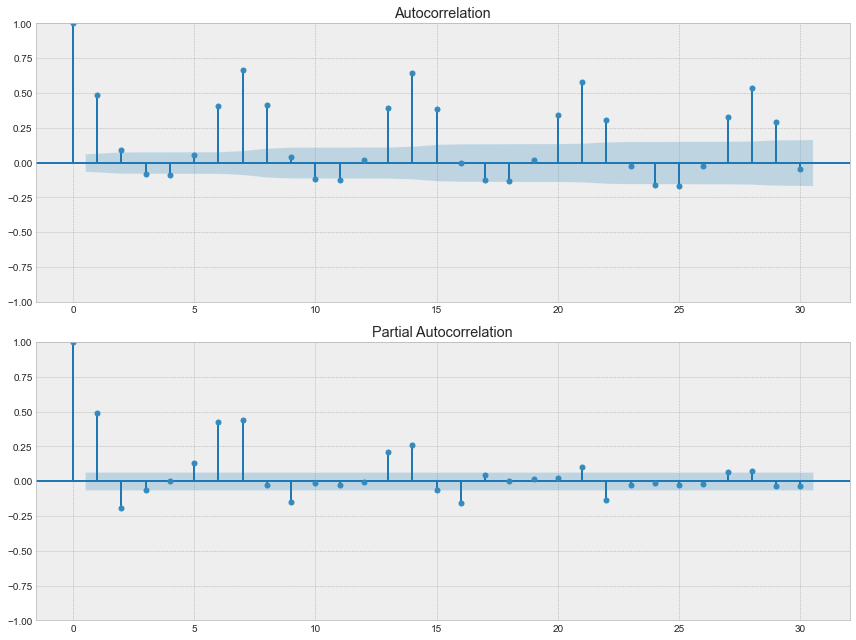

Adelaide_ITA


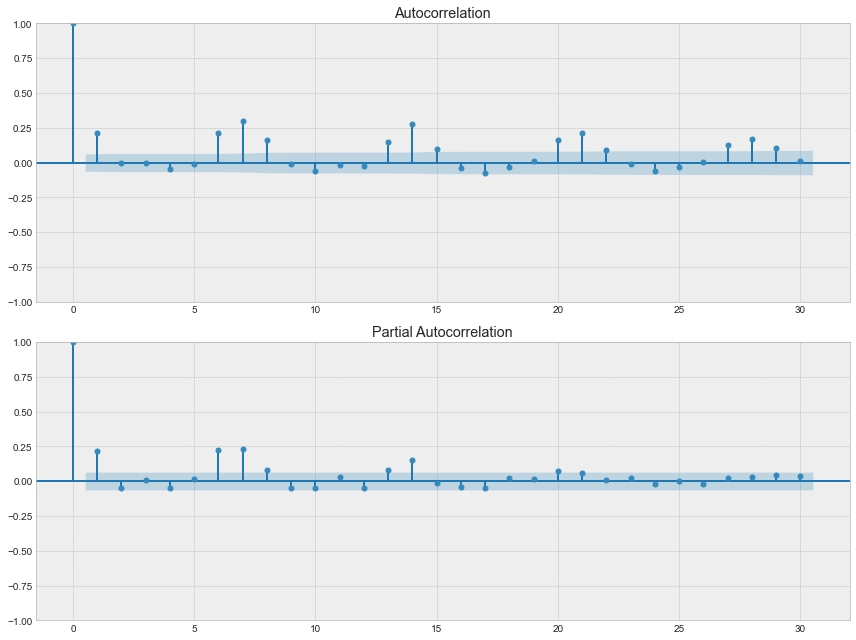

Brisbane_ITA


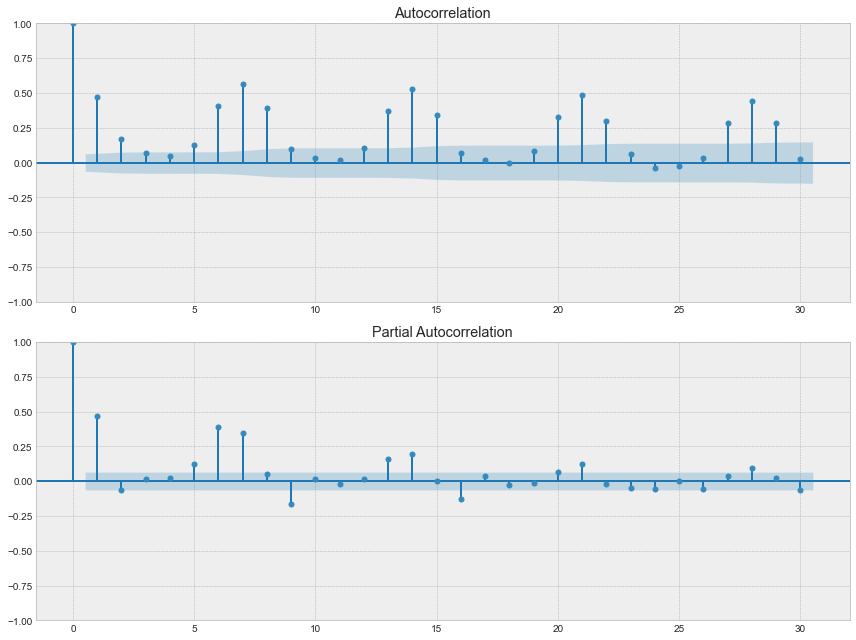

Melbourne_ITA


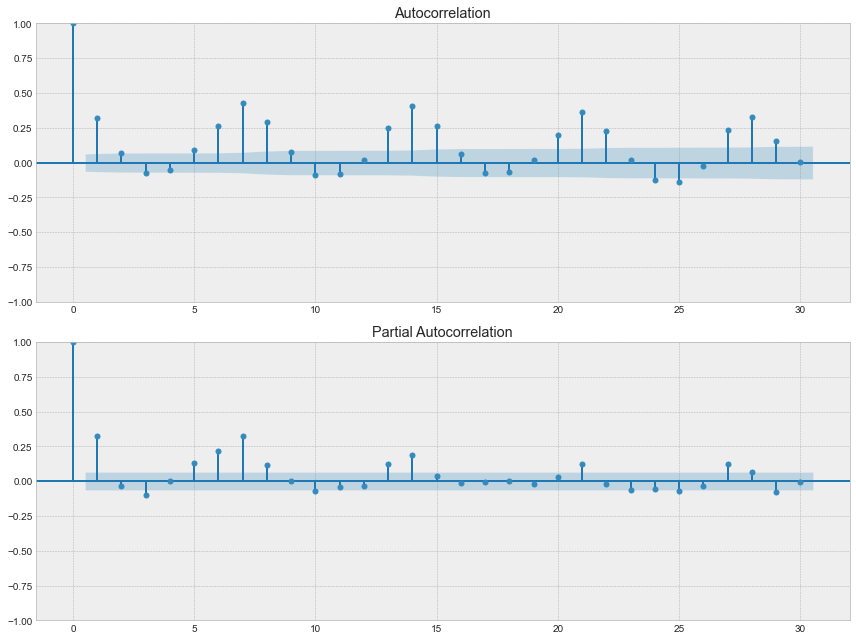

Perth_IDC


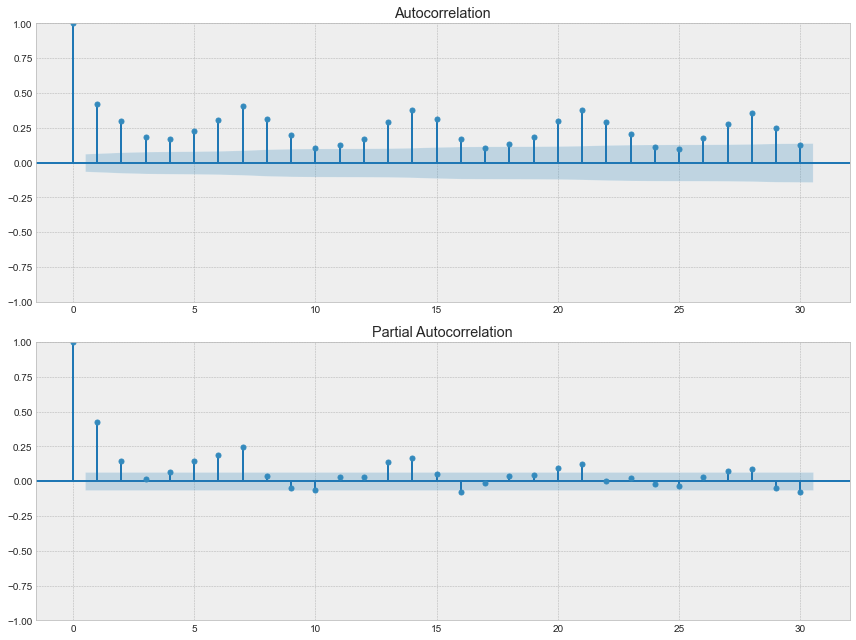

Villawood_IDC


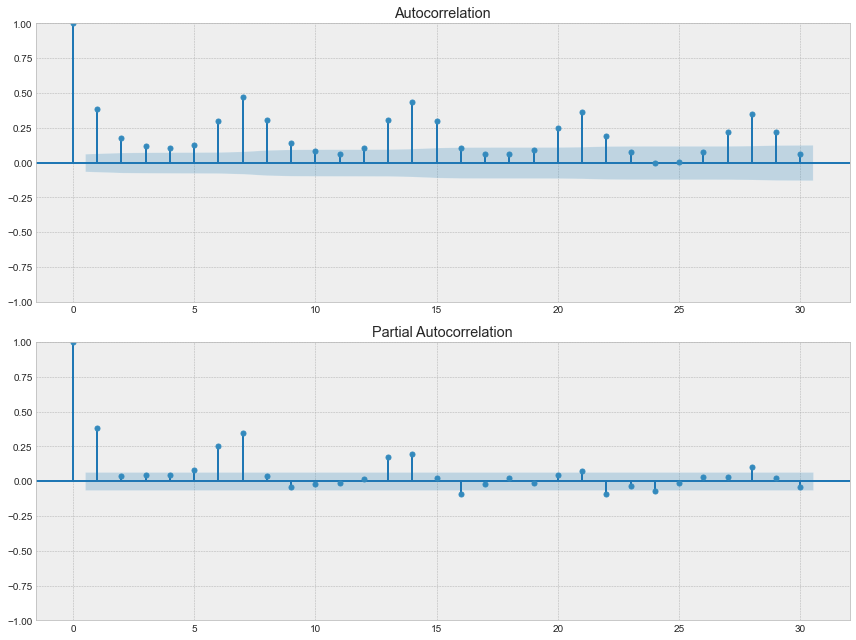

Yongah_Hill_IDC


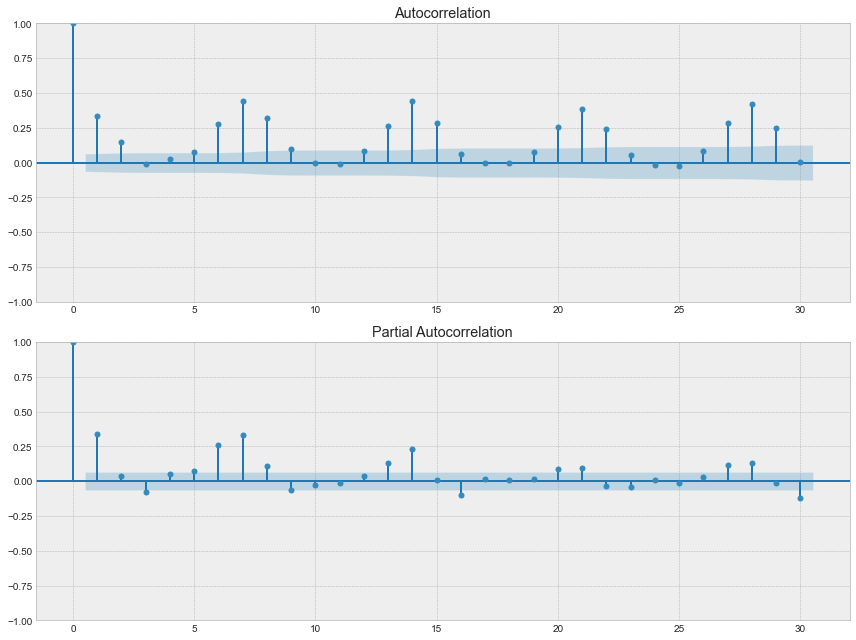

In [26]:
import statsmodels.tsa.api as smt

for col in df_workorder_tasks_one_hot_encoded_daily.columns[1:8]:
    with plt.style.context('bmh'):    
        print(col)
        fig = plt.figure(figsize=(12, 9))
        layout = (2, 1)
        acf_ax = plt.subplot2grid(layout, (0, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 0))
        
        # Use the flattened list in the ACF and PACF plots
        smt.graphics.plot_pacf(df_workorder_tasks_one_hot_encoded_daily[col], ax=pacf_ax, lags=30)
        smt.graphics.plot_acf(df_workorder_tasks_one_hot_encoded_daily[col], ax=acf_ax, lags=30)
        plt.tight_layout()

    plt.show()

In [27]:
import statsmodels.tsa.api as smt

for col in  df_workorder_tasks_one_hot_encoded_daily.columns[1:8]:
    lags = range(1, 15)
    for lag in lags: 
        df_workorder_tasks_one_hot_encoded_daily[f'{col}_Lag_{lag}'] = df_workorder_tasks_one_hot_encoded_daily[col].shift(lag)
        df_workorder_tasks_one_hot_encoded_daily[f'{col}_step_{lag}'] = df_workorder_tasks_one_hot_encoded_daily[col].shift(-lag)
        

In [28]:
df_workorder_tasks_one_hot_encoded_daily.dropna(inplace=True)
df_workorder_tasks_one_hot_encoded_daily.head()

,date,Work_Orders,Adelaide_ITA,Brisbane_ITA,Melbourne_ITA,Perth_IDC,Villawood_IDC,Yongah_Hill_IDC,month,year,day_of_week,day_of_month,day_of_year,Work_Orders_Lag_1,Work_Orders_step_1,Work_Orders_Lag_2,Work_Orders_step_2,Work_Orders_Lag_3,Work_Orders_step_3,Work_Orders_Lag_4,Work_Orders_step_4,Work_Orders_Lag_5,Work_Orders_step_5,Work_Orders_Lag_6,Work_Orders_step_6,Work_Orders_Lag_7,Work_Orders_step_7,Work_Orders_Lag_8,Work_Orders_step_8,Work_Orders_Lag_9,Work_Orders_step_9,Work_Orders_Lag_10,Work_Orders_step_10,Work_Orders_Lag_11,Work_Orders_step_11,Work_Orders_Lag_12,Work_Orders_step_12,Work_Orders_Lag_13,Work_Orders_step_13,Work_Orders_Lag_14,Work_Orders_step_14,Adelaide_ITA_Lag_1,Adelaide_ITA_step_1,Adelaide_ITA_Lag_2,Adelaide_ITA_step_2,Adelaide_ITA_Lag_3,Adelaide_ITA_step_3,Adelaide_ITA_Lag_4,Adelaide_ITA_step_4,Adelaide_ITA_Lag_5,...,Villawood_IDC_Lag_4,Villawood_IDC_step_4,Villawood_IDC_Lag_5,Villawood_IDC_step_5,Villawood_IDC_Lag_6,Villawood_IDC_step_6,Villawood_IDC_Lag_7,Villawood_IDC_step_7,Villawood_IDC_Lag_8,Villawood_IDC_step_8,Villawood_IDC_Lag_9,Villawood_IDC_step_9,Villawood_IDC_Lag_10,Villawood_IDC_step_10,Villawood_IDC_Lag_11,Villawood_IDC_step_11,Villawood_IDC_Lag_12,Villawood_IDC_step_12,Villawood_IDC_Lag_13,Villawood_IDC_step_13,Villawood_IDC_Lag_14,Villawood_IDC_step_14,Yongah_Hill_IDC_Lag_1,Yongah_Hill_IDC_step_1,Yongah_Hill_IDC_Lag_2,Yongah_Hill_IDC_step_2,Yongah_Hill_IDC_Lag_3,Yongah_Hill_IDC_step_3,Yongah_Hill_IDC_Lag_4,Yongah_Hill_IDC_step_4,Yongah_Hill_IDC_Lag_5,Yongah_Hill_IDC_step_5,Yongah_Hill_IDC_Lag_6,Yongah_Hill_IDC_step_6,Yongah_Hill_IDC_Lag_7,Yongah_Hill_IDC_step_7,Yongah_Hill_IDC_Lag_8,Yongah_Hill_IDC_step_8,Yongah_Hill_IDC_Lag_9,Yongah_Hill_IDC_step_9,Yongah_Hill_IDC_Lag_10,Yongah_Hill_IDC_step_10,Yongah_Hill_IDC_Lag_11,Yongah_Hill_IDC_step_11,Yongah_Hill_IDC_Lag_12,Yongah_Hill_IDC_step_12,Yongah_Hill_IDC_Lag_13,Yongah_Hill_IDC_step_13,Yongah_Hill_IDC_Lag_14,Yongah_Hill_IDC_step_14
14,2020-05-15,20,2,7,3,2,3,3,5,2020,4,15,136,20.0000,6.0000,28.0000,5.0000,30.0000,22.0000,23.0000,23.0000,9.0000,35.0000,8.0000,20.0000,22.0000,23.0000,24.0000,9.0000,25.0000,2.0000,30.0000,17.0000,19.0000,28.0000,7.0000,30.0000,9.0000,28.0000,21.0000,37.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,8.0000,5.0000,1.0000,12.0000,2.0000,3.0000,2.0000,7.0000,6.0000,3.0000,9.0000,0.0000,9.0000,4.0000,5.0000,6.0000,2.0000,3.0000,2.0000,6.0000,5.0000,7.0000,5.0000,0.0000,2.0000,0.0000,8.0000,1.0000,3.0000,3.0000,2.0000,4.0000,0.0000,1.0000,4.0000,7.0000,7.0000,3.0000,2.0000,0.0000,3.0000,2.0000,2.0000,4.0000,0.0000,5.0000,3.0000,6.0000,2.0000,9.0000
15,2020-05-16,6,0,1,1,0,4,0,5,2020,5,16,137,20.0000,5.0000,20.0000,22.0000,28.0000,23.0000,30.0000,35.0000,23.0000,20.0000,9.0000,23.0000,8.0000,9.0000,22.0000,2.0000,24.0000,17.0000,25.0000,28.0000,30.0000,30.0000,19.0000,28.0000,7.0000,37.0000,9.0000,16.0000,2.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,...,6.0000,12.0000,8.0000,3.0000,1.0000,7.0000,2.0000,3.0000,2.0000,0.0000,6.0000,4.0000,9.0000,6.0000,9.0000,3.0000,5.0000,6.0000,2.0000,7.0000,2.0000,7.0000,3.0000,0.0000,5.0000,1.0000,2.0000,3.0000,8.0000,4.0000,3.0000,1.0000,2.0000,7.0000,0.0000,3.0000,4.0000,0.0000,7.0000,2.0000,2.0000,4.0000,3.0000,5.0000,2.0000,6.0000,0.0000,9.0000,3.0000,1.0000
16,2020-05-17,5,0,1,2,0,2,0,5,2020,6,17,138,6.0000,22.0000,20.0000,23.0000,20.0000,35.0000,28.0000,20.0000,30.0000,23.0000,23.0000,9.0000,9.0000,2.0000,8.0000,17.0000,22.0000,28.0000,24.0000,30.0000,25.0000,28.0000,30.0000,37.0000,19.0000,16.0000,7.0000,7.0000,0.0000,0.0000,2.0000,0.0000,1.0000,2.0000,0.0000,0.0000,0.0000,...,6.0000,3.0000,6.0000,7.0000,8.0000,3.0000,1.0000,0.0000,2.0000,4.0000,2.0000,6.0000,6.0000,3.0000,9.0000,6.0000,9.0000,7.0000,5.0000,7.0000,2.0000,2.0000,0.0000,1.0000,3.0000,3.0000,5.0000,4.0000,2.0000,1.0000,8.0000,7.0000,3.0000,3.0000,2.0000,0.0000,0.0000,2.0000,4.0000,4.0000,7.0000,5.0000,2.0000,6.0000,3.0000,9.0000,2.0000,1.0000,0.0000,1.0000
17,2020-05

In [29]:
df_workorder_tasks_one_hot_encoded_daily.info()

<class 'pandas.core.frame.DataFrame'>
Index: 928 entries, 14 to 941
Columns: 209 entries, date to Yongah_Hill_IDC_step_14
dtypes: datetime64[ns](1), float64(196), int32(5), int64(7)
memory usage: 1.5 MB


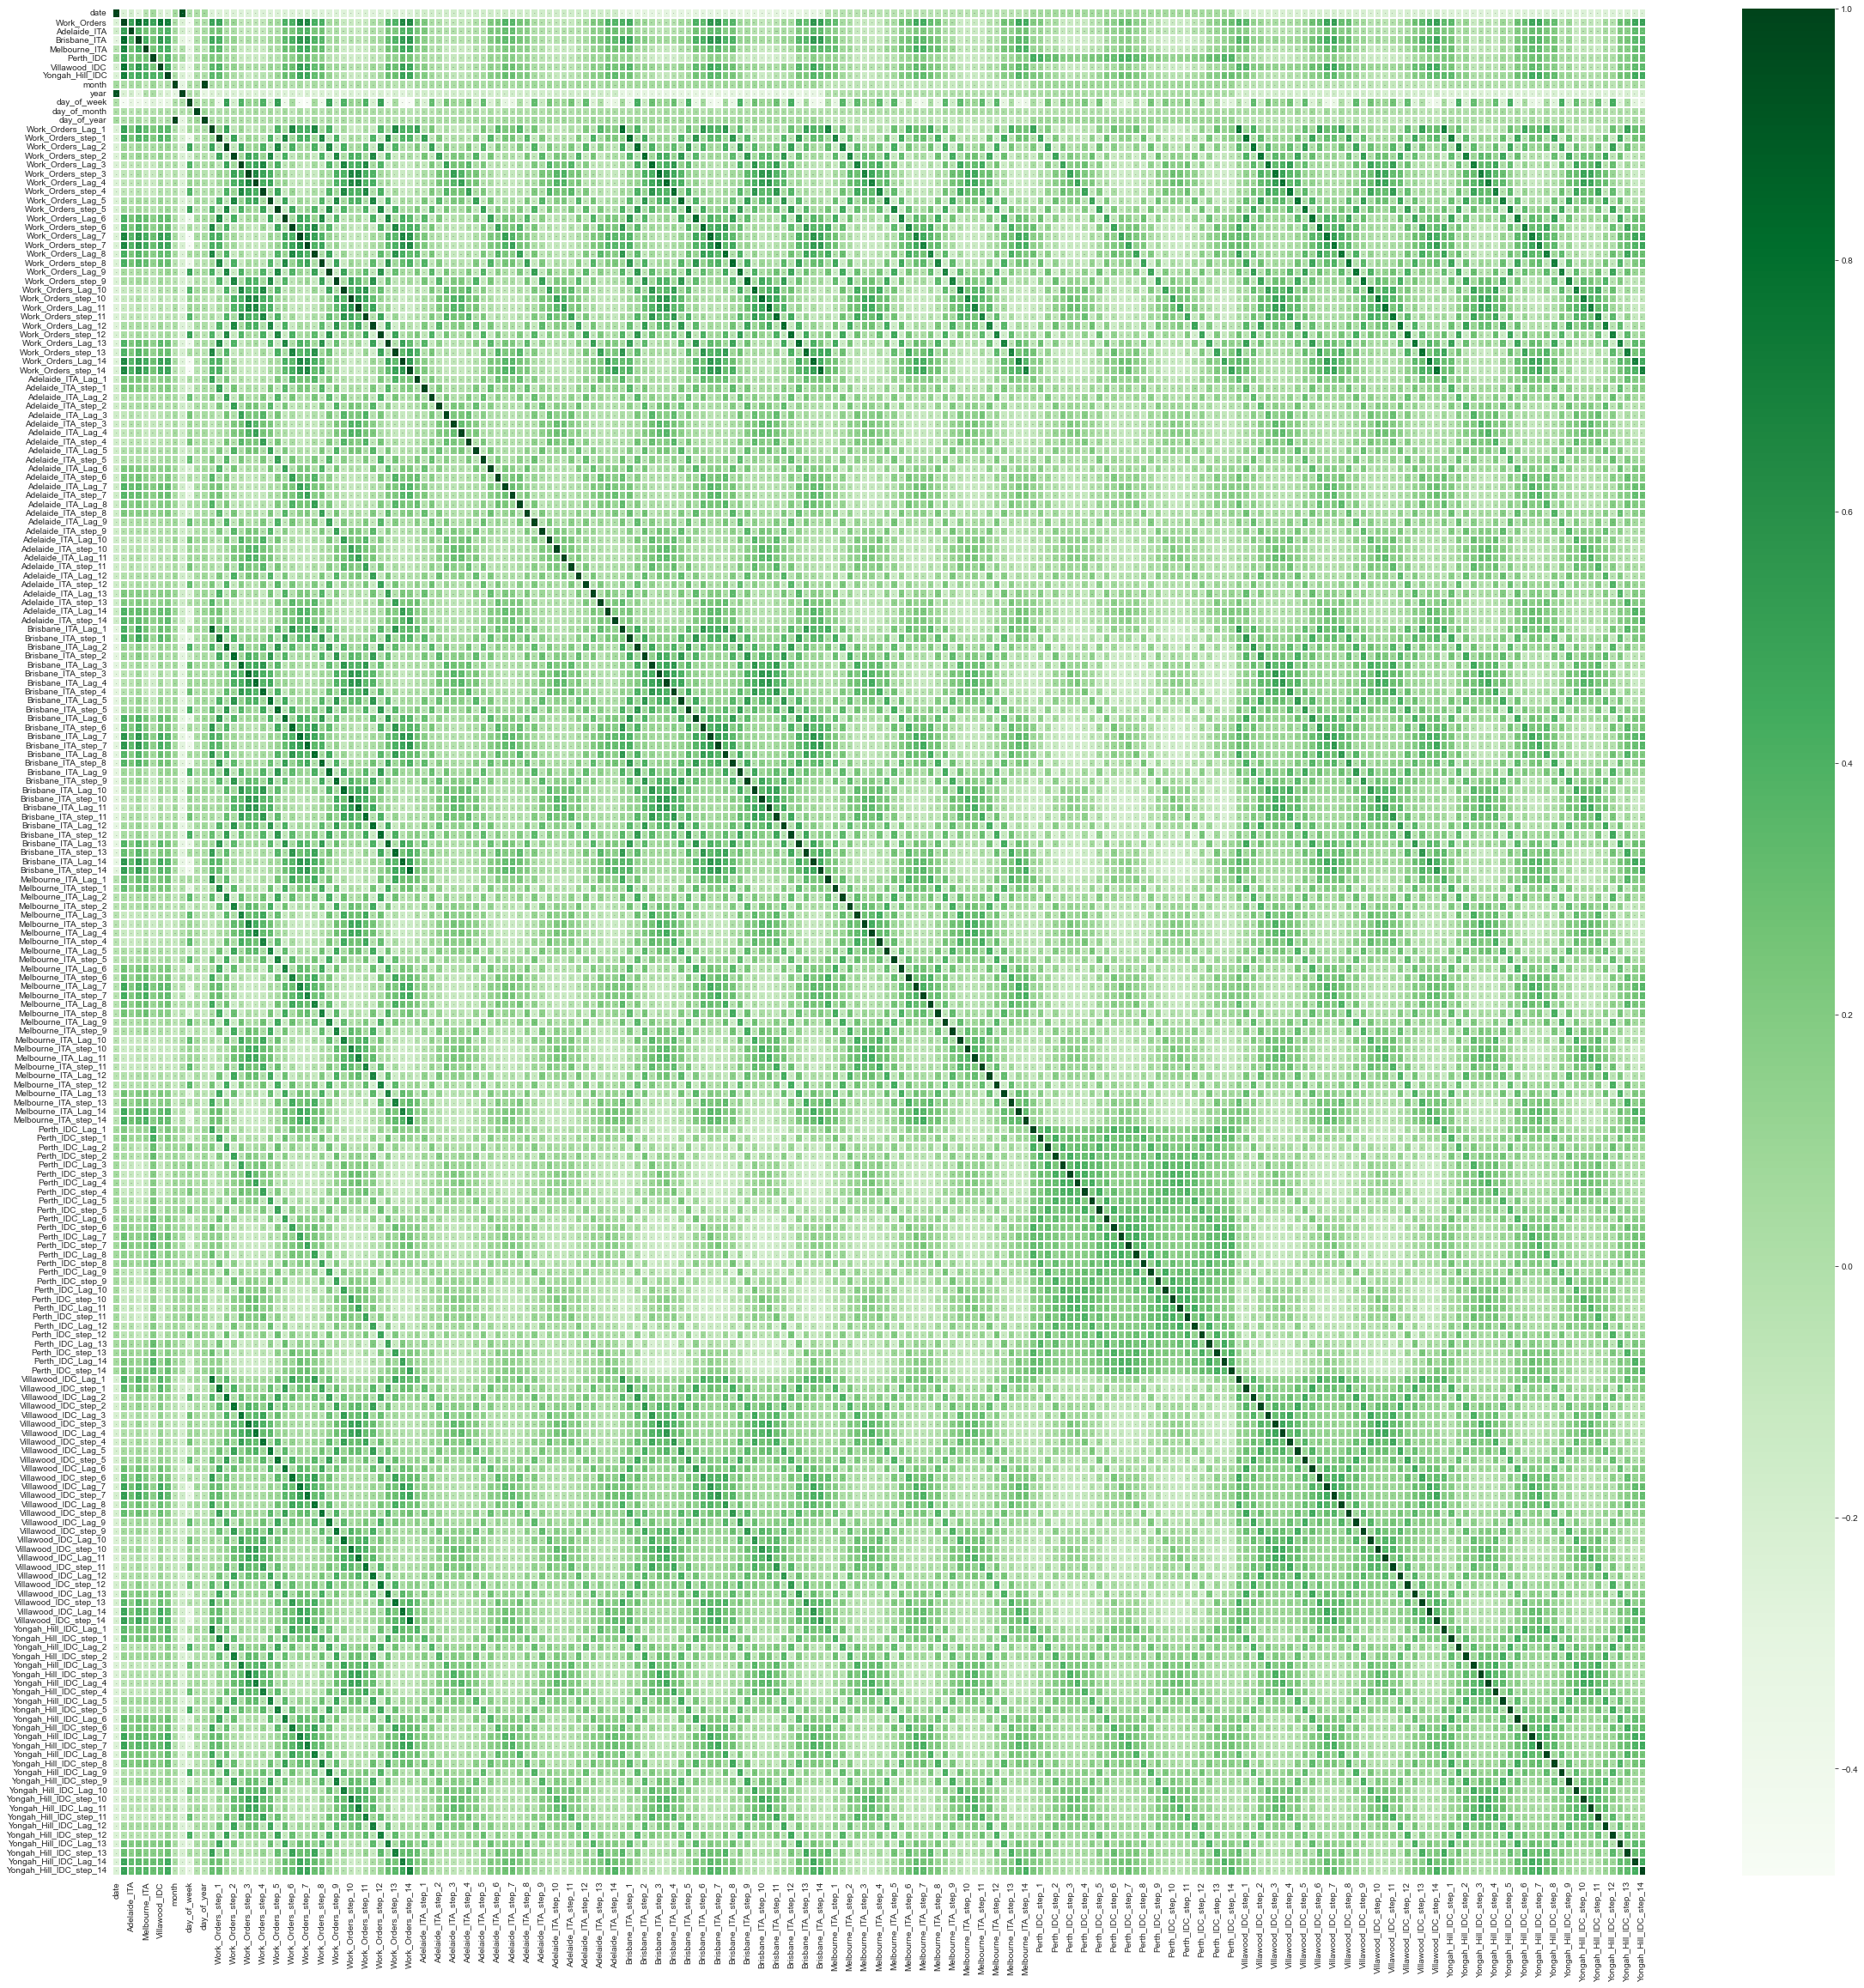

In [30]:
plt.figure(figsize=(40, 40))
sns.heatmap(df_workorder_tasks_one_hot_encoded_daily.corr(), annot=True, cmap="Greens", linewidths=0.1, annot_kws={"fontsize":0});

In [31]:
df_workorder_tasks_one_hot_encoded_daily.to_csv('split_out_data.csv', index=False)

In [32]:
df_workorder_tasks_one_hot_encoded_daily.set_index('date',inplace=True)
X = df_workorder_tasks_one_hot_encoded_daily.drop([col for col in df_workorder_tasks_one_hot_encoded_daily.columns if 'step' in col], axis=1)
y = df_workorder_tasks_one_hot_encoded_daily[[col for col in df_workorder_tasks_one_hot_encoded_daily.columns if 'step' in col]]

In [33]:
X.shape

(928, 110)

In [34]:
X.columns

Index(['Work_Orders', 'Adelaide_ITA', 'Brisbane_ITA', 'Melbourne_ITA',
       'Perth_IDC', 'Villawood_IDC', 'Yongah_Hill_IDC', 'month', 'year',
       'day_of_week',
       ...
       'Yongah_Hill_IDC_Lag_5', 'Yongah_Hill_IDC_Lag_6',
       'Yongah_Hill_IDC_Lag_7', 'Yongah_Hill_IDC_Lag_8',
       'Yongah_Hill_IDC_Lag_9', 'Yongah_Hill_IDC_Lag_10',
       'Yongah_Hill_IDC_Lag_11', 'Yongah_Hill_IDC_Lag_12',
       'Yongah_Hill_IDC_Lag_13', 'Yongah_Hill_IDC_Lag_14'],
      dtype='object', length=110)

In [35]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle = False)

## Hybrid Model:

In [36]:
import numpy as np
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [37]:
# Train the XGBoost model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
xgb_preds = xgb_model.predict(X_test).round()
lr_preds = lr_model.predict(X_test).round()

# Combine predictions (simple average)
hybrid_preds = ((xgb_preds + lr_preds) / 2).round()

# Evaluate performance
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
hybrid_rmse = np.sqrt(mean_squared_error(y_test, hybrid_preds))
print(f"XGBoost RMSE: {xgb_rmse}")
print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Hybrid Model RMSE: {hybrid_rmse}")
print('-'*20)
xgb_mae = mean_absolute_error(y_test, xgb_preds)
lr_mae = mean_absolute_error(y_test, lr_preds)
hybrid_mae = mean_absolute_error(y_test, hybrid_preds)
print(f"XGBoost MAE: {xgb_mae}")
print(f"Linear Regression MAE: {lr_mae}")
print(f"Hybrid Model MAE: {hybrid_mae}")
print('-'*20)
xgb_R2 = r2_score(y_test, xgb_preds)
lr_R2 = r2_score(y_test, lr_preds)
hybrid_R2 = r2_score(y_test, hybrid_preds)
print(f"XGBoost R2: {xgb_R2}")
print(f"Linear Regression R2: {lr_R2}")
print(f"Hybrid Model R2: {hybrid_R2}")

XGBoost RMSE: 4.795957353270215
Linear Regression RMSE: 4.811865409200542
Hybrid Model RMSE: 4.659293840434145
--------------------
XGBoost MAE: 2.9487601492209787
Linear Regression MAE: 2.8990563967522487
Hybrid Model MAE: 2.8615317094579766
--------------------
XGBoost R2: 0.05632673999427737
Linear Regression R2: 0.07386127326623793
Hybrid Model R2: 0.09709276019048615


### XGB:
#### Feture Selection:

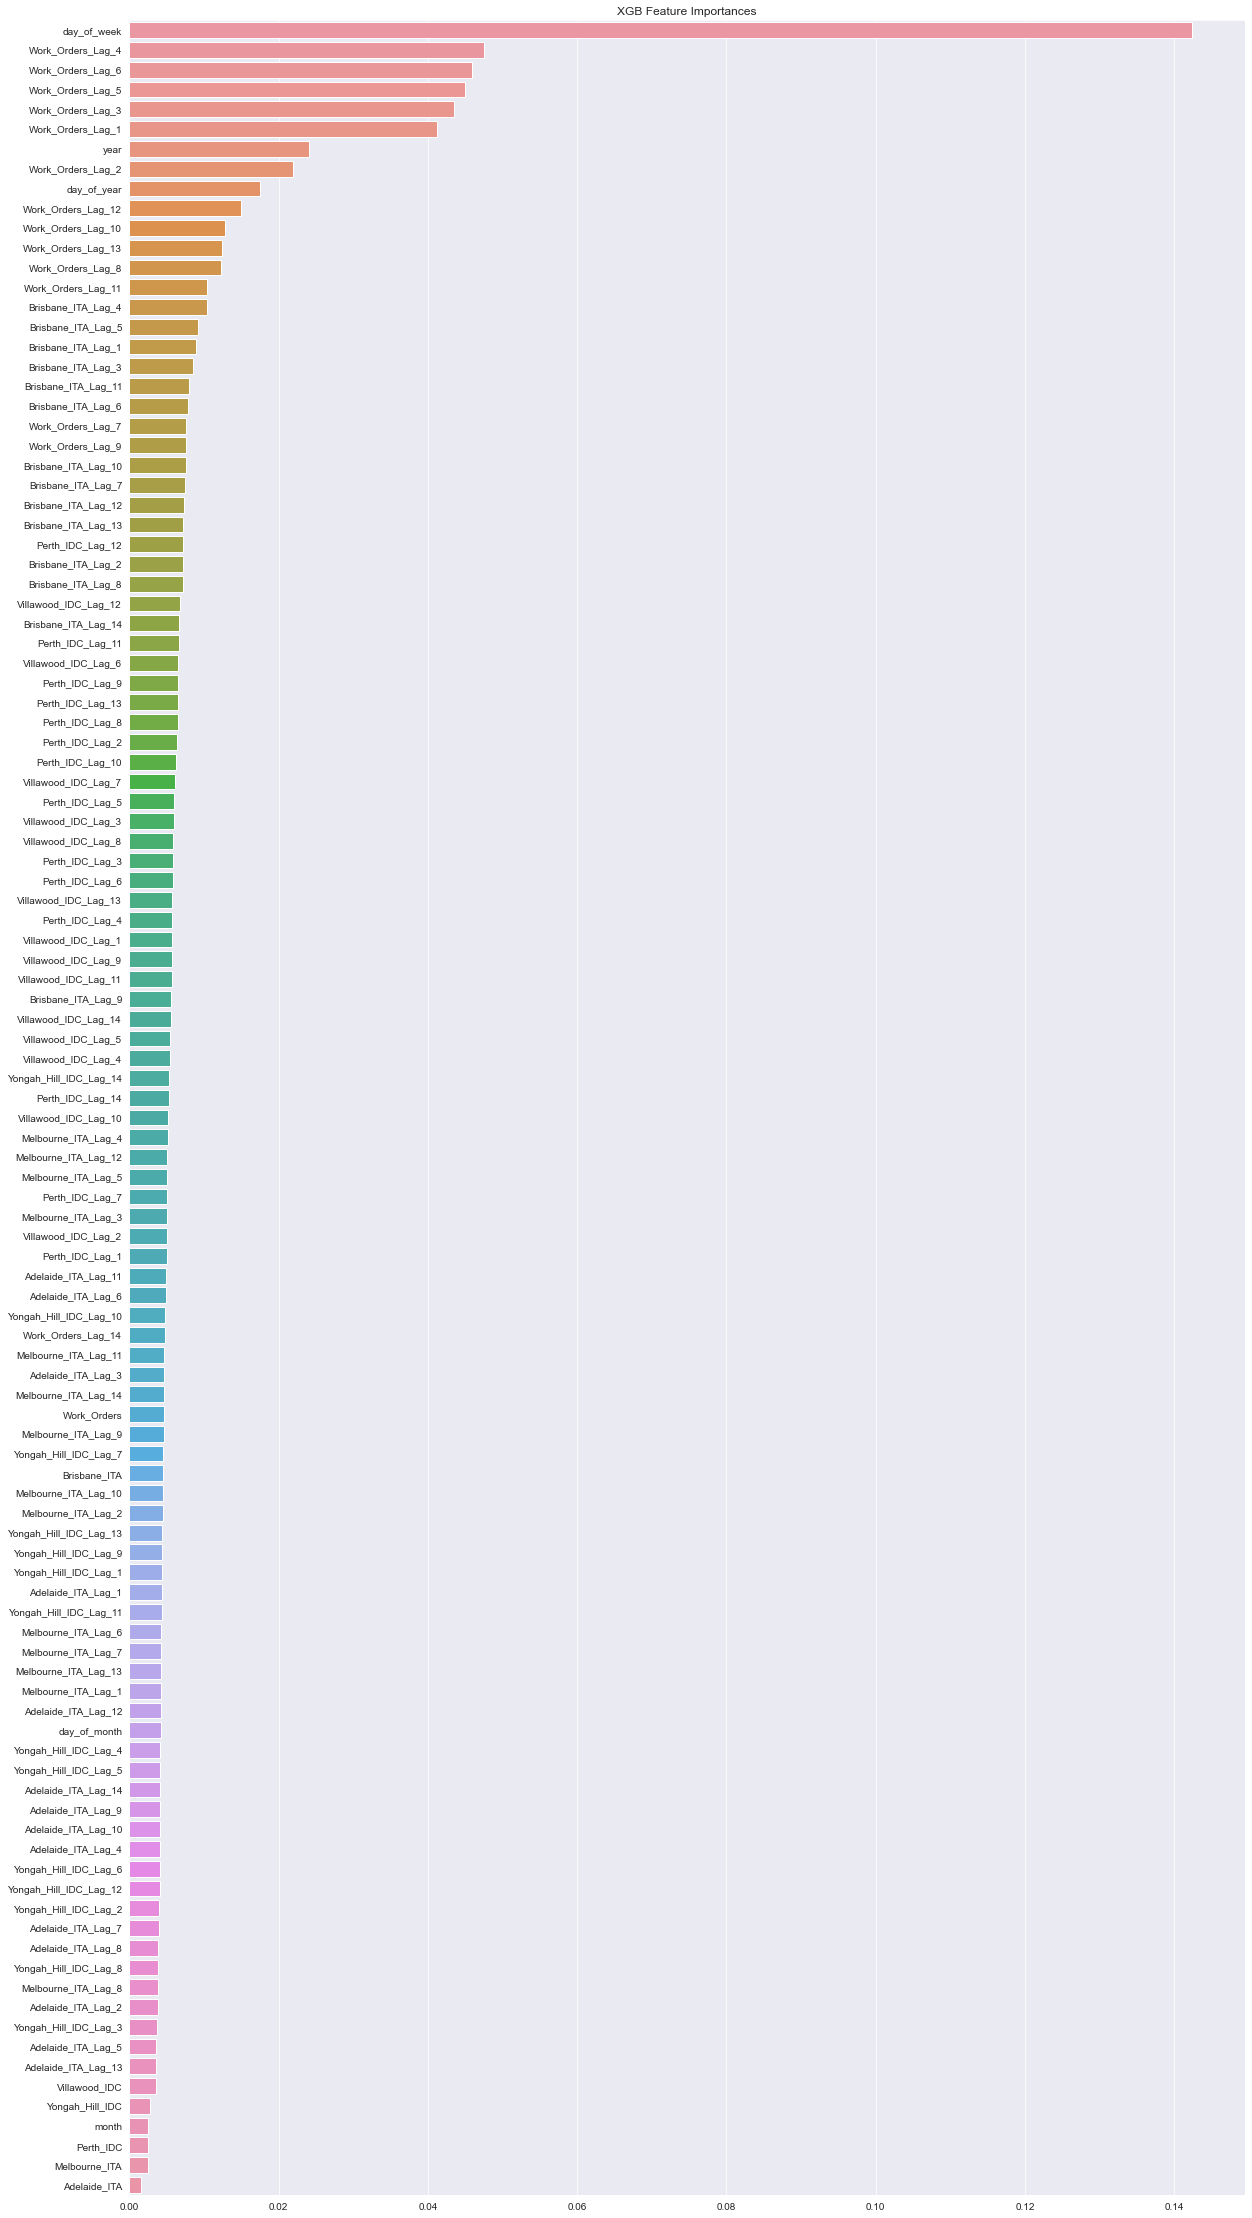

In [70]:
# Get XGBoost feature importances
xgb_feature_importances = xgb_model.feature_importances_
xgb_feature_importances_dict = {}

for feature, importance in zip(X_train.columns, xgb_feature_importances):
    xgb_feature_importances_dict[feature] = importance

# Create a figure with the desired size
plt.figure(figsize=(20, 40))  # Adjust the width and height as per your preference

# Assuming you have already defined `feature_importances` and `np.abs(feature_importances)`
xgb_feature_importances = pd.Series(xgb_feature_importances_dict.values(),index=xgb_feature_importances_dict.keys()).abs().sort_values(ascending=False)
sns.barplot(x=xgb_feature_importances, y=xgb_feature_importances.index)
xgb_feature_importances.to_csv('xgb_split_hy_fi.csv', header=False)

# Display the plot
plt.title('XGB Feature Importances')
plt.show()

In [43]:
sorted_cols = xgb_feature_importances.index.to_list()
sorted_cols

['day_of_week',
 'Work_Orders_Lag_4',
 'Work_Orders_Lag_6',
 'Work_Orders_Lag_5',
 'Work_Orders_Lag_3',
 'Work_Orders_Lag_1',
 'year',
 'Work_Orders_Lag_2',
 'day_of_year',
 'Work_Orders_Lag_12',
 'Work_Orders_Lag_10',
 'Work_Orders_Lag_13',
 'Work_Orders_Lag_8',
 'Work_Orders_Lag_11',
 'Brisbane_ITA_Lag_4',
 'Brisbane_ITA_Lag_5',
 'Brisbane_ITA_Lag_1',
 'Brisbane_ITA_Lag_3',
 'Brisbane_ITA_Lag_11',
 'Brisbane_ITA_Lag_6',
 'Work_Orders_Lag_7',
 'Work_Orders_Lag_9',
 'Brisbane_ITA_Lag_10',
 'Brisbane_ITA_Lag_7',
 'Brisbane_ITA_Lag_12',
 'Brisbane_ITA_Lag_13',
 'Perth_IDC_Lag_12',
 'Brisbane_ITA_Lag_2',
 'Brisbane_ITA_Lag_8',
 'Villawood_IDC_Lag_12',
 'Brisbane_ITA_Lag_14',
 'Perth_IDC_Lag_11',
 'Villawood_IDC_Lag_6',
 'Perth_IDC_Lag_9',
 'Perth_IDC_Lag_13',
 'Perth_IDC_Lag_8',
 'Perth_IDC_Lag_2',
 'Perth_IDC_Lag_10',
 'Villawood_IDC_Lag_7',
 'Perth_IDC_Lag_5',
 'Villawood_IDC_Lag_3',
 'Villawood_IDC_Lag_8',
 'Perth_IDC_Lag_3',
 'Perth_IDC_Lag_6',
 'Villawood_IDC_Lag_13',
 'Perth_IDC_Lag

In [46]:
cols_and_scores = {}
# Convert X_train and X_test to DataFrames
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

for n in range(1,int(len(sorted_cols))+1):

    cols = sorted_cols[:n]

    # Make predictions on the test set
    classifier = XGBRegressor(random_state=42)
    classifier.fit(X_train[cols], y_train)
    predictions = classifier.predict(X_test[cols]).round()
    

    r2score = np.sqrt(mean_squared_error(y_test,predictions))

    cols_and_scores[-r2score] = cols
    print(n,' : ', r2score,'RMSE')

1  :  5.214133154345011 RMSE
2  :  5.405663526032861 RMSE
3  :  5.560330038213559 RMSE
4  :  5.337449722607693 RMSE
5  :  5.230573429182398 RMSE
6  :  5.050979955195844 RMSE
7  :  5.185837637596368 RMSE
8  :  5.157227320582654 RMSE
9  :  5.5796937393685075 RMSE
10  :  5.497830082454035 RMSE
11  :  5.385358363642078 RMSE
12  :  5.353224373363534 RMSE
13  :  5.31507806722102 RMSE
14  :  5.347133506346543 RMSE
15  :  5.314572279738786 RMSE
16  :  5.233540821298558 RMSE
17  :  5.205593200640135 RMSE
18  :  5.201418165522852 RMSE
19  :  5.262069837753716 RMSE
20  :  5.163850308730117 RMSE
21  :  5.077585453730795 RMSE
22  :  5.127205659596217 RMSE
23  :  5.032416313914258 RMSE
24  :  4.99821122270917 RMSE
25  :  4.957300669918336 RMSE
26  :  5.012591124633229 RMSE
27  :  5.041260522780715 RMSE
28  :  5.053596871831865 RMSE
29  :  4.9668199059414 RMSE
30  :  4.984516293202372 RMSE
31  :  4.976243761612119 RMSE
32  :  4.961327290961601 RMSE
33  :  4.948528130276054 RMSE
34  :  4.9801228775359

In [47]:
len(pd.Series(cols_and_scores)[max(cols_and_scores.keys())]) # Printing the best set columns for the model.

100

#### XGB Results after After Feature Selection:

In [48]:
xgb_new_cols = cols_and_scores[max(cols_and_scores.keys())]

# Make predictions on the test set
classifier = XGBRegressor(random_state=42)
classifier.fit(X_train[xgb_new_cols], y_train)
predictions = classifier.predict(X_test[xgb_new_cols]).round()

xgb_rmse = np.sqrt(mean_squared_error(y_test, predictions))
xgb_mae = mean_absolute_error(y_test, predictions)
xgb_R2 = r2_score(y_test, predictions)

print(f"XGBoost RMSE: {xgb_rmse}")
print(f"XGBoost MAE: {xgb_mae}")
print(f"XGBoost R2: {xgb_R2}")

XGBoost RMSE: 4.795454013629994
XGBoost MAE: 2.95139346061005
XGBoost R2: 0.057146825472871546


#### XGB Hyperparameter Tuning:

In [49]:
from sklearn.model_selection import GridSearchCV

In [50]:
# Define the parameter grid for GridSearch
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5]
}

# Initialize the XGBoost regressor
xgb_regressor = XGBRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(xgb_regressor, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train[xgb_new_cols], y_train)

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
xgb_best_predictions = best_xgb_model.predict(X_test[xgb_new_cols]).round()

print(f"Best XGBoost Parameters: {grid_search.best_params_}")
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_best_predictions))
xgb_mae = mean_absolute_error(y_test, xgb_best_predictions)
xgb_R2 = r2_score(y_test, xgb_best_predictions)

print(f"XGBoost RMSE: {xgb_rmse}")
print(f"XGBoost MAE: {xgb_mae}")
print(f"XGBoost R2: {xgb_R2}")

Best XGBoost Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
XGBoost RMSE: 4.470307766264665
XGBoost MAE: 2.821263989466754
XGBoost R2: 0.16206520211585504


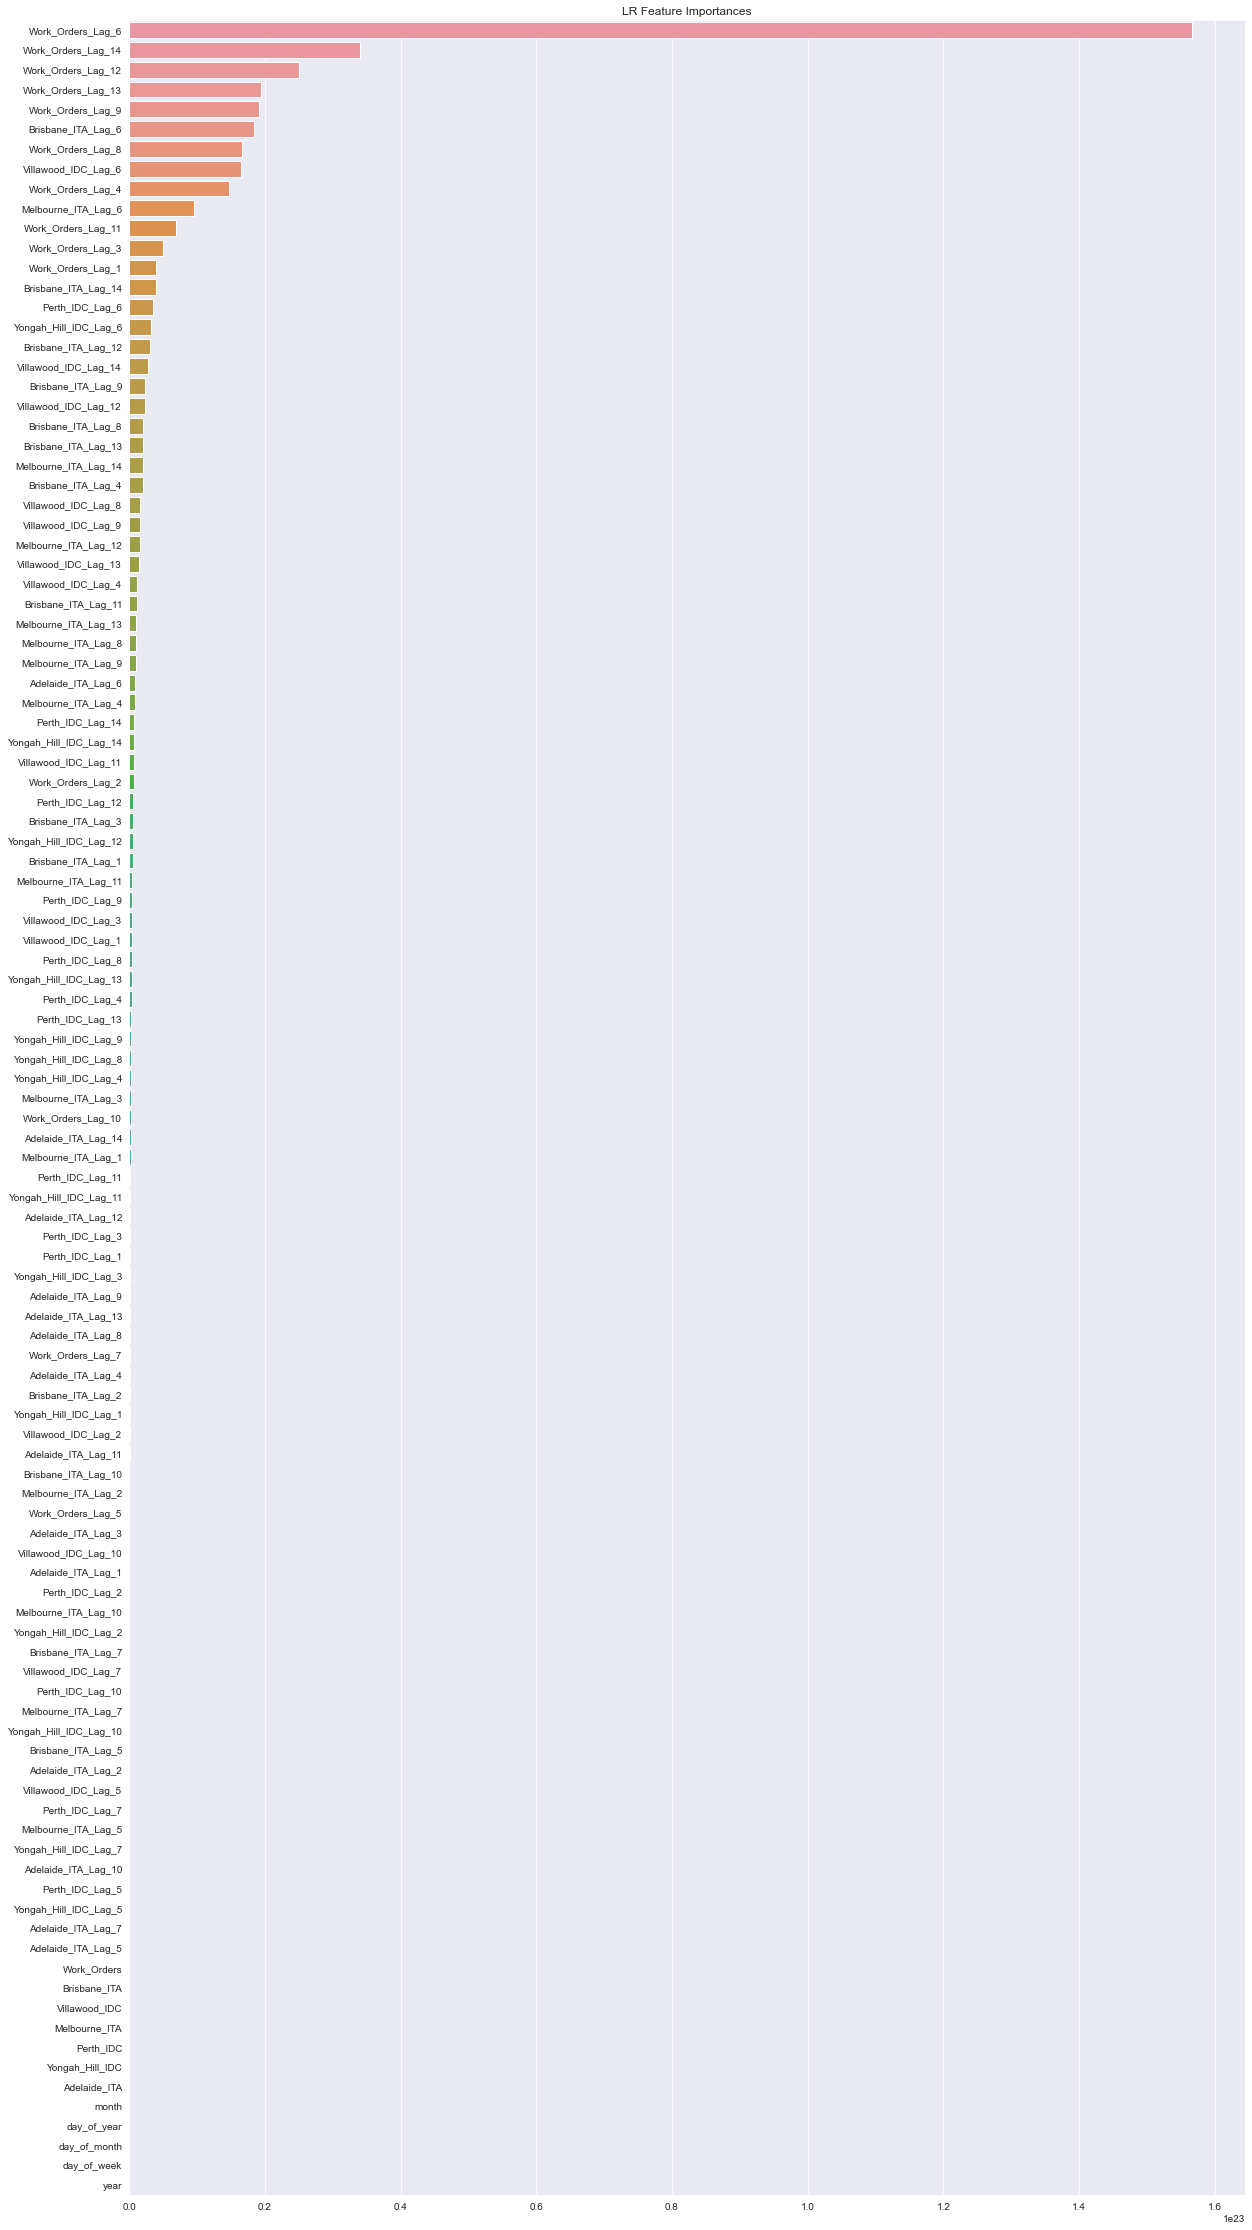

In [69]:
from eli5.permutation_importance import get_score_importances

cols = X.columns.to_list()

# Calculate feature importance using permutation importance
def calculate_permutation_importance(model, X, y):
    base_score, score_decreases = get_score_importances(
        lambda x,y: r2_score(y, model.predict(x).round()), X, y, n_iter=3, random_state=42
    )
    lr_feature_importances = np.mean(score_decreases, axis=0)
    feature_names = cols
    return dict(zip(feature_names, lr_feature_importances))


# Calculate permutation importance
lr_feature_importances = calculate_permutation_importance(lr_model, X_test.values, y_test)

sorted_cols = pd.Series(lr_feature_importances).abs().sort_values(ascending=False)

# Create a figure with the desired size
plt.figure(figsize=(20, 40))


lr_feature_importances = pd.Series(lr_feature_importances.values(),index=lr_feature_importances.keys()).abs().sort_values(ascending=False)
sns.barplot(x=lr_feature_importances, y=lr_feature_importances.index)
lr_feature_importances.to_csv('lr_split_hy_fi.csv', header=False)

plt.title('LR Feature Importances')
# Display the plot
plt.show()

In [58]:
sorted_cols = lr_feature_importances.index.to_list()
sorted_cols

['Work_Orders_Lag_6',
 'Work_Orders_Lag_14',
 'Work_Orders_Lag_12',
 'Work_Orders_Lag_13',
 'Work_Orders_Lag_9',
 'Brisbane_ITA_Lag_6',
 'Work_Orders_Lag_8',
 'Villawood_IDC_Lag_6',
 'Work_Orders_Lag_4',
 'Melbourne_ITA_Lag_6',
 'Work_Orders_Lag_11',
 'Work_Orders_Lag_3',
 'Work_Orders_Lag_1',
 'Brisbane_ITA_Lag_14',
 'Perth_IDC_Lag_6',
 'Yongah_Hill_IDC_Lag_6',
 'Brisbane_ITA_Lag_12',
 'Villawood_IDC_Lag_14',
 'Brisbane_ITA_Lag_9',
 'Villawood_IDC_Lag_12',
 'Brisbane_ITA_Lag_8',
 'Brisbane_ITA_Lag_13',
 'Melbourne_ITA_Lag_14',
 'Brisbane_ITA_Lag_4',
 'Villawood_IDC_Lag_8',
 'Villawood_IDC_Lag_9',
 'Melbourne_ITA_Lag_12',
 'Villawood_IDC_Lag_13',
 'Villawood_IDC_Lag_4',
 'Brisbane_ITA_Lag_11',
 'Melbourne_ITA_Lag_13',
 'Melbourne_ITA_Lag_8',
 'Melbourne_ITA_Lag_9',
 'Adelaide_ITA_Lag_6',
 'Melbourne_ITA_Lag_4',
 'Perth_IDC_Lag_14',
 'Yongah_Hill_IDC_Lag_14',
 'Villawood_IDC_Lag_11',
 'Work_Orders_Lag_2',
 'Perth_IDC_Lag_12',
 'Brisbane_ITA_Lag_3',
 'Yongah_Hill_IDC_Lag_12',
 'Brisbane_

In [59]:
cols_and_scores = {}

for n in range(1,int(len(sorted_cols))+1):

    cols = sorted_cols[:n]

    # Make predictions on the test set
    classifier = LinearRegression()
    classifier.fit(X_train[cols], y_train)
    predictions = classifier.predict(X_test[cols]).round()
    

    r2score = np.sqrt(mean_squared_error(y_test,predictions))

    cols_and_scores[-r2score] = cols
    print(n,' : ', r2score,'RMSE')

1  :  5.450004177461039 RMSE
2  :  5.549970493786069 RMSE
3  :  5.45688509215022 RMSE
4  :  5.439898442300292 RMSE
5  :  5.145725859745728 RMSE
6  :  5.177166237659267 RMSE
7  :  5.1198173964859 RMSE
8  :  5.1522358586121975 RMSE
9  :  4.937096080594248 RMSE
10  :  4.936673809288976 RMSE
11  :  4.914420121049838 RMSE
12  :  4.846570675418646 RMSE
13  :  4.713808568694254 RMSE
14  :  4.716391560573007 RMSE
15  :  4.698677788981676 RMSE
16  :  4.706703859867305 RMSE
17  :  4.71024590675314 RMSE
18  :  4.735325205917043 RMSE
19  :  4.743670927538431 RMSE
20  :  4.7566637825408735 RMSE
21  :  4.750443195659729 RMSE
22  :  4.746538186207612 RMSE
23  :  4.747312511385245 RMSE
24  :  4.757067435501812 RMSE
25  :  4.761701224528765 RMSE
26  :  4.769138131420384 RMSE
27  :  4.775621565221757 RMSE
28  :  4.779720895734765 RMSE
29  :  4.780627555504184 RMSE
30  :  4.782038848160363 RMSE
31  :  4.776460089824492 RMSE
32  :  4.781625830011304 RMSE
33  :  4.786740151872135 RMSE
34  :  4.786740151872

In [60]:
len(pd.Series(cols_and_scores)[max(cols_and_scores.keys())]) # Printing the best set columns for the model.

103

#### LR Scores After Feature Selection:

In [61]:
lr_new_cols = cols_and_scores[max(cols_and_scores.keys())]

# Make predictions on the test set
classifier = LinearRegression()
classifier.fit(X_train[lr_new_cols], y_train)
predictions = classifier.predict(X_test[lr_new_cols]).round()

lr_rmse = np.sqrt(mean_squared_error(y_test, predictions))
lr_mae = mean_absolute_error(y_test, predictions)
lr_R2 = r2_score(y_test, predictions)

print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Linear Regression MAE: {lr_mae}")
print(f"Linear Regression R2: {lr_R2}")

Linear Regression RMSE: 4.655489137465899
Linear Regression MAE: 2.881171823568137
Linear Regression R2: 0.11984870713411128


#### LR Hyperparameter Tuning:

In [62]:
# Define the hyperparameters to tune
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False],
    'copy_X': [True, False],
}
# Create the Linear Regression model
lr_regressor = LinearRegression()

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=lr_regressor, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train[lr_new_cols], y_train)

# Get the best model from the grid search
lr_best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
lr_best_predictions = lr_best_model.predict(X_test[lr_new_cols]).round()


# Calculate evaluation metrics
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_best_predictions))
lr_mae = mean_absolute_error(y_test, lr_best_predictions)
lr_R2 = r2_score(y_test, lr_best_predictions)

print("Best Model Hyperparameters:", lr_best_model.get_params())
print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Linear Regression MAE: {lr_mae}")
print(f"Linear Regression R2: {lr_R2}")

Best Model Hyperparameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': True}
Linear Regression RMSE: 4.463368569385136
Linear Regression MAE: 2.7197717796796135
Linear Regression R2: 0.1448024464877138


### Hybrid Final Results:

In [63]:
# Combine predictions (simple average)
hybrid_best_preds = ((xgb_best_predictions + lr_best_predictions) / 2).round()

# Evaluate performance
hybrid_rmse = np.sqrt(mean_squared_error(y_test, hybrid_best_preds))
print(f"Hybrid Model RMSE: {hybrid_rmse}")
hybrid_mae = mean_absolute_error(y_test, hybrid_best_preds)
print(f"Hybrid Model MAE: {hybrid_mae}")
hybrid_R2 = r2_score(y_test, hybrid_best_preds)
print(f"Hybrid Model R2: {hybrid_R2}")

Hybrid Model RMSE: 4.3636663914288585
Hybrid Model MAE: 2.7179065174456882
Hybrid Model R2: 0.16598338997183432


#### Displaying the Hybrid Model Predictions:

In [64]:
X_test_hybrid = X_test.copy()
X_test_hybrid[y_test.columns] = y_test
X_test_hybrid[['Hybrid'+ col for col in y_test.columns]] = hybrid_best_preds
X_test_hybrid[['xgb'+ col for col in y_test.columns]] = xgb_best_predictions
X_test_hybrid[['lr'+ col for col in y_test.columns]] = lr_best_predictions
# Create a datetime index
X_test_hybrid.head(10)

,Work_Orders,Adelaide_ITA,Brisbane_ITA,Melbourne_ITA,Perth_IDC,Villawood_IDC,Yongah_Hill_IDC,month,year,day_of_week,day_of_month,day_of_year,Work_Orders_Lag_1,Work_Orders_Lag_2,Work_Orders_Lag_3,Work_Orders_Lag_4,Work_Orders_Lag_5,Work_Orders_Lag_6,Work_Orders_Lag_7,Work_Orders_Lag_8,Work_Orders_Lag_9,Work_Orders_Lag_10,Work_Orders_Lag_11,Work_Orders_Lag_12,Work_Orders_Lag_13,Work_Orders_Lag_14,Adelaide_ITA_Lag_1,Adelaide_ITA_Lag_2,Adelaide_ITA_Lag_3,Adelaide_ITA_Lag_4,Adelaide_ITA_Lag_5,Adelaide_ITA_Lag_6,Adelaide_ITA_Lag_7,Adelaide_ITA_Lag_8,Adelaide_ITA_Lag_9,Adelaide_ITA_Lag_10,Adelaide_ITA_Lag_11,Adelaide_ITA_Lag_12,Adelaide_ITA_Lag_13,Adelaide_ITA_Lag_14,Brisbane_ITA_Lag_1,Brisbane_ITA_Lag_2,Brisbane_ITA_Lag_3,Brisbane_ITA_Lag_4,Brisbane_ITA_Lag_5,Brisbane_ITA_Lag_6,Brisbane_ITA_Lag_7,Brisbane_ITA_Lag_8,Brisbane_ITA_Lag_9,Brisbane_ITA_Lag_10,...,lrMelbourne_ITA_step_7,lrMelbourne_ITA_step_8,lrMelbourne_ITA_step_9,lrMelbourne_ITA_step_10,lrMelbourne_ITA_step_11,lrMelbourne_ITA_step_12,lrMelbourne_ITA_step_13,lrMelbourne_ITA_step_14,lrPerth_IDC_step_1,lrPerth_IDC_step_2,lrPerth_IDC_step_3,lrPerth_IDC_step_4,lrPerth_IDC_step_5,lrPerth_IDC_step_6,lrPerth_IDC_step_7,lrPerth_IDC_step_8,lrPerth_IDC_step_9,lrPerth_IDC_step_10,lrPerth_IDC_step_11,lrPerth_IDC_step_12,lrPerth_IDC_step_13,lrPerth_IDC_step_14,lrVillawood_IDC_step_1,lrVillawood_IDC_step_2,lrVillawood_IDC_step_3,lrVillawood_IDC_step_4,lrVillawood_IDC_step_5,lrVillawood_IDC_step_6,lrVillawood_IDC_step_7,lrVillawood_IDC_step_8,lrVillawood_IDC_step_9,lrVillawood_IDC_step_10,lrVillawood_IDC_step_11,lrVillawood_IDC_step_12,lrVillawood_IDC_step_13,lrVillawood_IDC_step_14,lrYongah_Hill_IDC_step_1,lrYongah_Hill_IDC_step_2,lrYongah_Hill_IDC_step_3,lrYongah_Hill_IDC_step_4,lrYongah_Hill_IDC_step_5,lrYongah_Hill_IDC_step_6,lrYongah_Hill_IDC_step_7,lrYongah_Hill_IDC_step_8,lrYongah_Hill_IDC_step_9,lrYongah_Hill_IDC_step_10,lrYongah_Hill_IDC_step_11,lrYongah_Hill_IDC_step_12,lrYongah_Hill_IDC_step_13,lrYongah_Hill_IDC_step_14
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-08-29,20,1,5,3,5,4,2,8,2022,0,29,241,7.0000,1.0000,4.0000,15.0000,17.0000,24.0000,23.0000,5.0000,2.0000,10.0000,31.0000,1.0000,3.0000,23.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,2.0000,1.0000,0.0000,2.0000,8.0000,5.0000,7.0000,5.0000,1.0000,1.0000,3.0000,...,3.0000,2.0000,2.0000,3.0000,1.0000,1.0000,2.0000,3.0000,2.0000,2.0000,2.0000,1.0000,1.0000,1.0000,2.0000,2.0000,2.0000,2.0000,1.0000,1.0000,1.0000,2.0000,3.0000,3.0000,5.0000,3.0000,1.0000,3.0000,5.0000,4.0000,4.0000,5.0000,2.0000,2.0000,3.0000,5.0000,1.0000,2.0000,3.0000,1.0000,0.0000,1.0000,2.0000,2.0000,2.0000,2.0000,1.0000,1.0000,1.0000,2.0000
2022-08-30,24,0,9,1,4,8,2,8,2022,1,30,242,20.0000,7.0000,1.0000,4.0000,15.0000,17.0000,24.0000,23.0000,5.0000,2.0000,10.0000,31.0000,1.0000,3.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,5.0000,1.0000,0.0000,2.0000,8.0000,5.0000,7.0000,5.0000,1.0000,1.0000,...,2.0000,2.0000,3.0000,1.0000,1.0000,2.0000,3.0000,3.0000,2.0000,2.0000,1.0000,1.0000,1.0000,2.0000,2.0000,2.0000,2.0000,1.0000,1.0000,1.0000,2.0000,2.0000,4.0000,5.0000,3.0000,1.0000,3.0000,5.0000,5.0000,4.0000,5.0000,3.0000,1.0000,3.0000,5.0000,5.0000,1.0000,3.0000,1.0000,0.0000,1.0000,2.0000,2.0000,2.0000,2.0000,1.0000,1.0000,1.0000,2.0000,2.0000
2022-08-31,36,0,13,10,5,4,4,8,2022,2,31,243,24.0000,20.0000,7.0000,1.0000,4.0000,15.0000,17.0000,24.0000,23.0000,5.0000,2.0000,10.0000,31.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,9.0000,5.0000,1.0000,0.0000,2.0000,8.0000,5.0000,7.0000,5.0000,1.0000,...,4.0000,4.0000,1.0000,1.0000,2.0000,3.0000,3.0000,4.0000,2.0000,2.0000,1.0000,1.0000,3.0000,3.0000,3.0000,2.0000,1.0000,1.0000,1.0000,2.0000,3.0000,2.0000,5.0000,3.0000,2.0000,3.0000,5.0000,5.0000,5.0000,5.0000,3.0000,2.0000,3.00

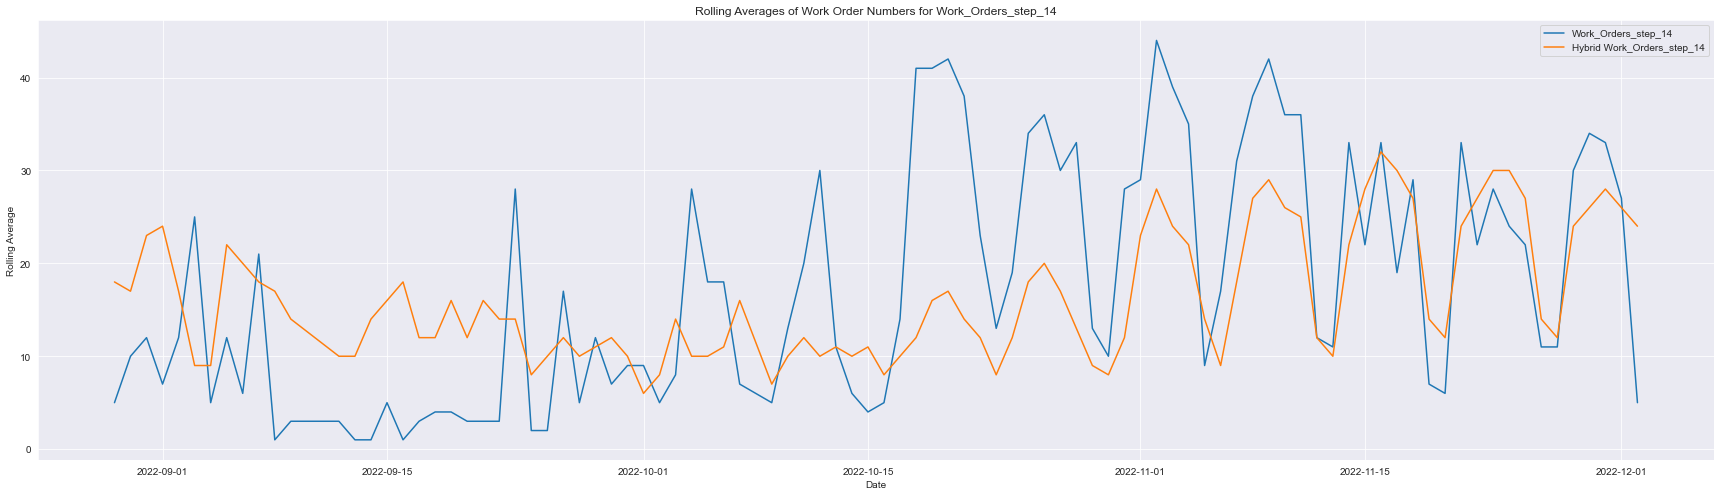

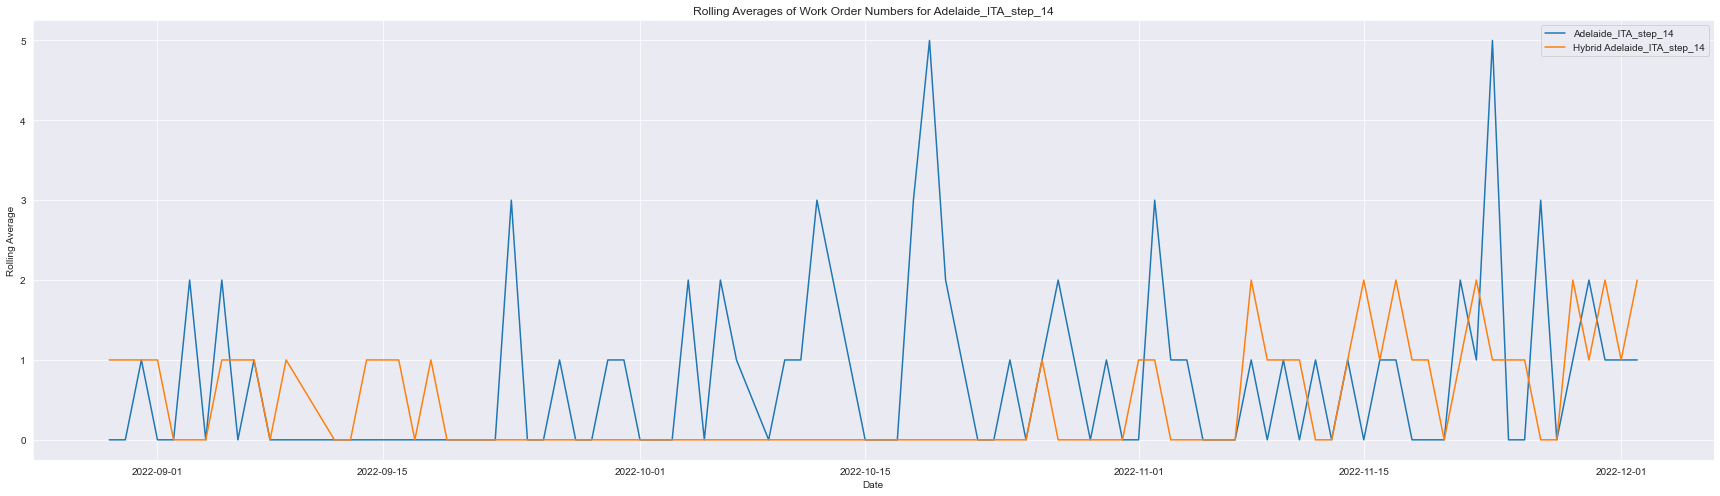

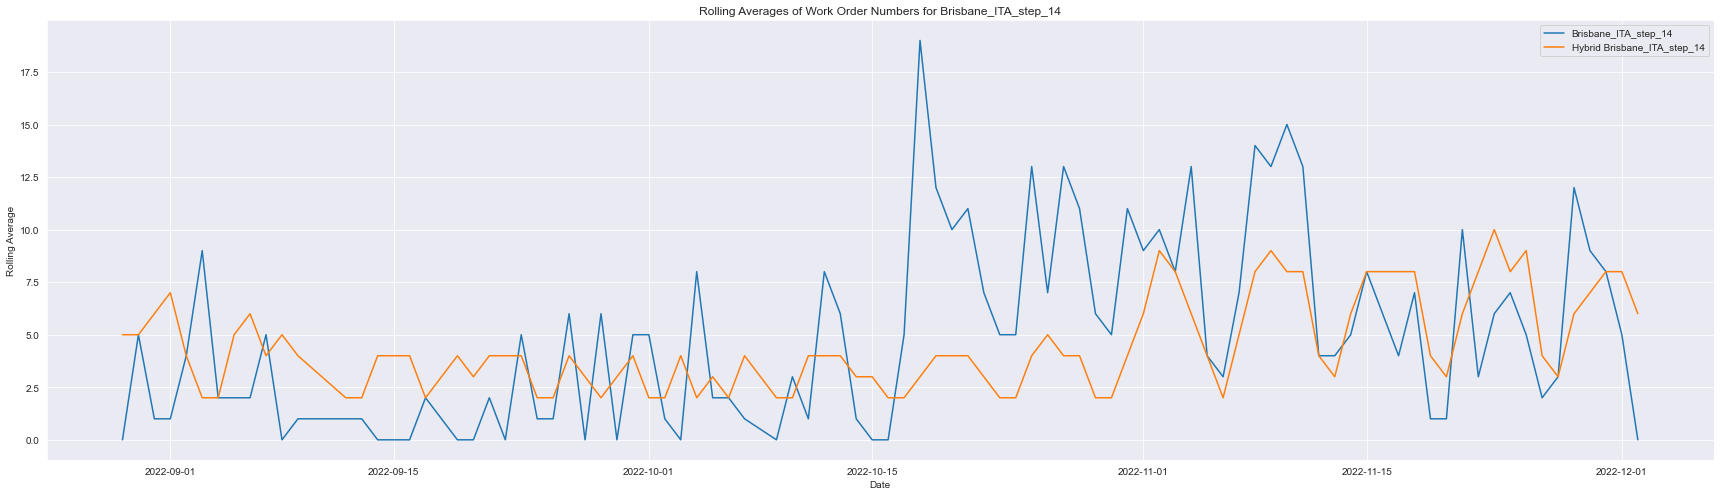

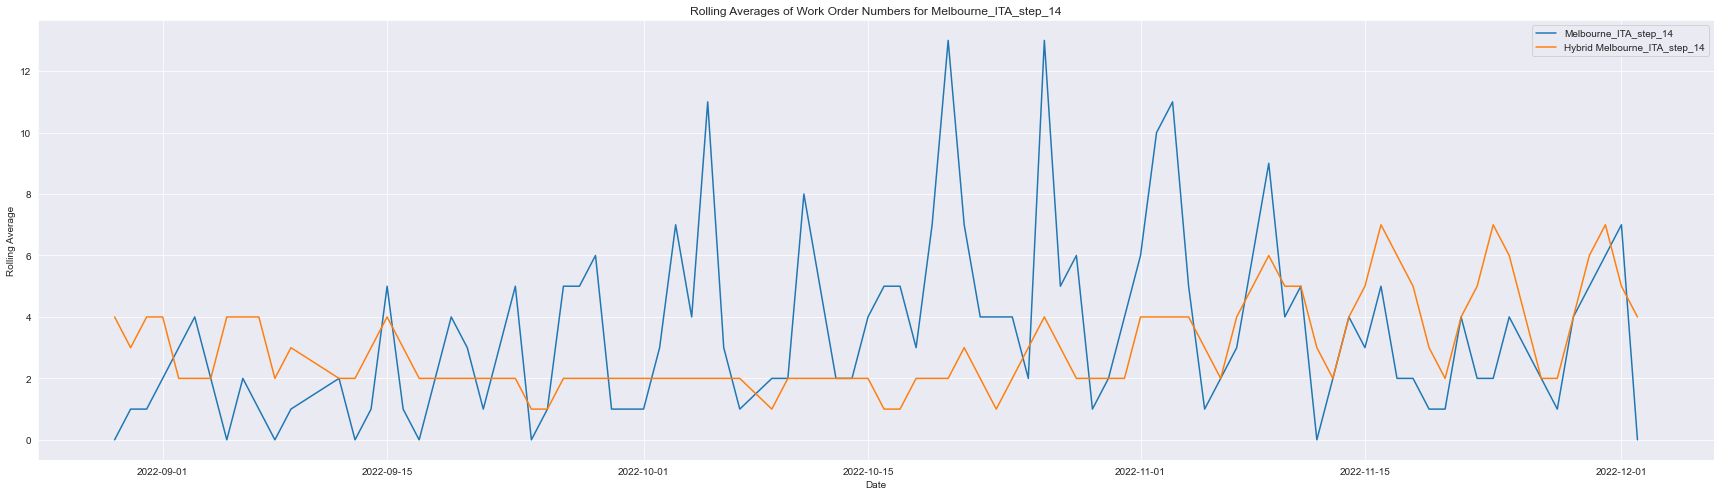

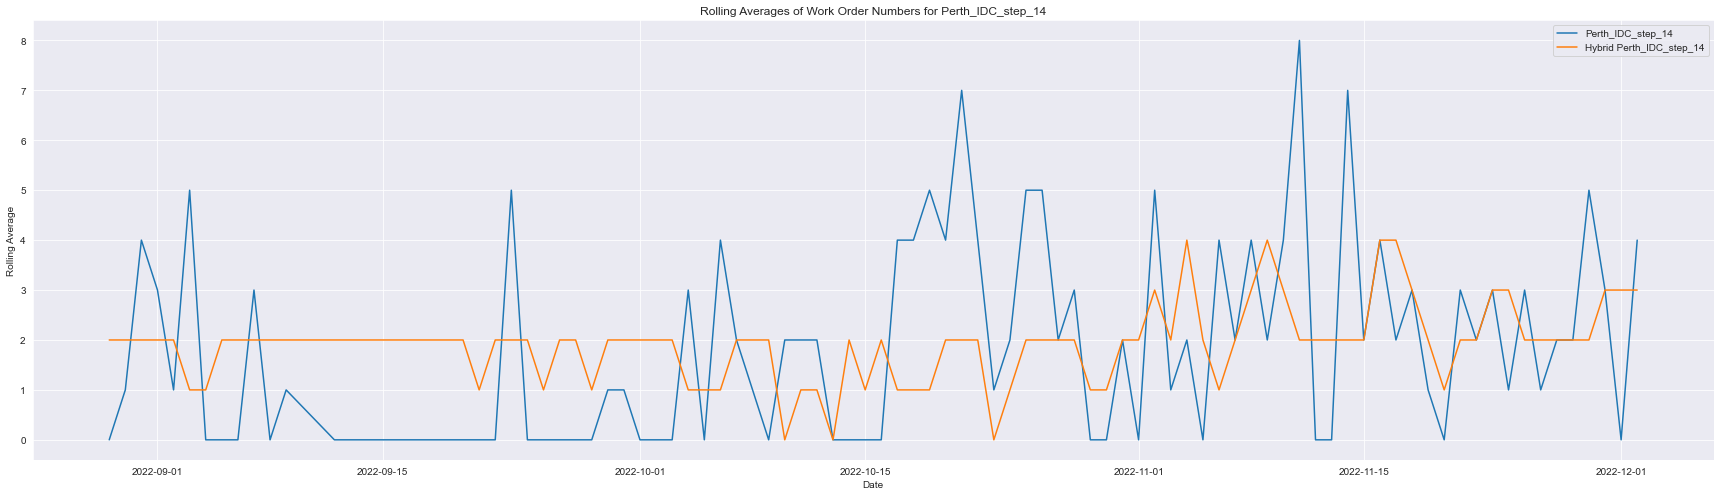

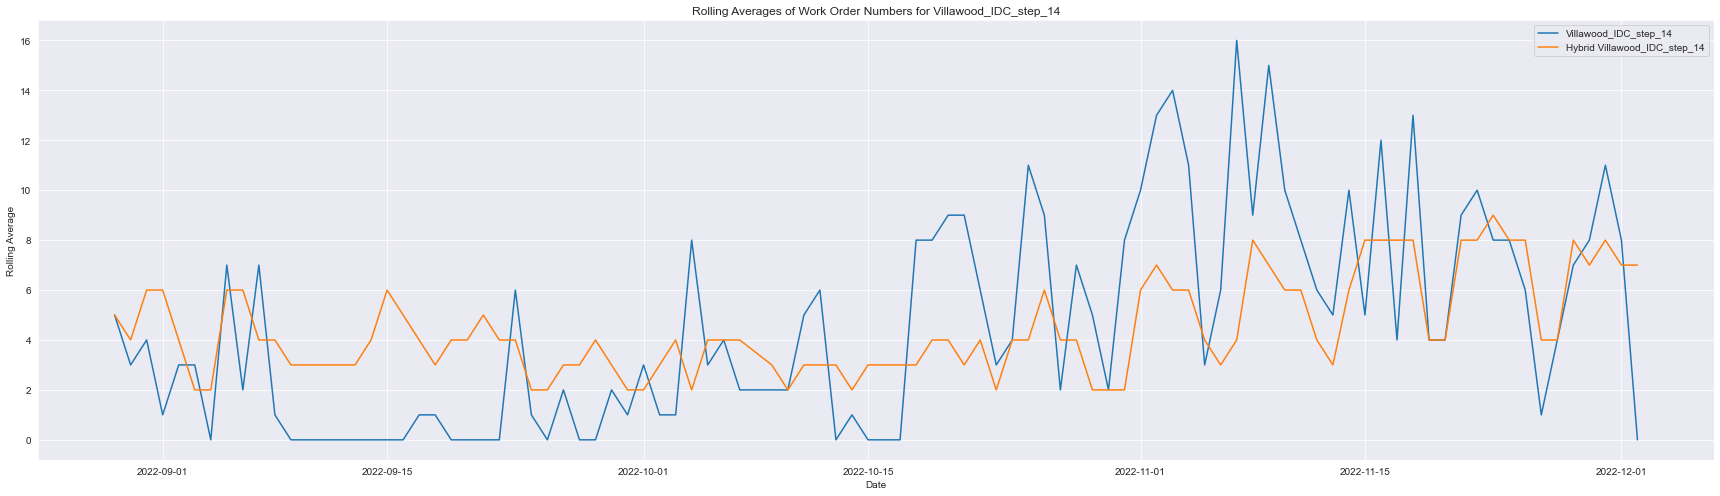

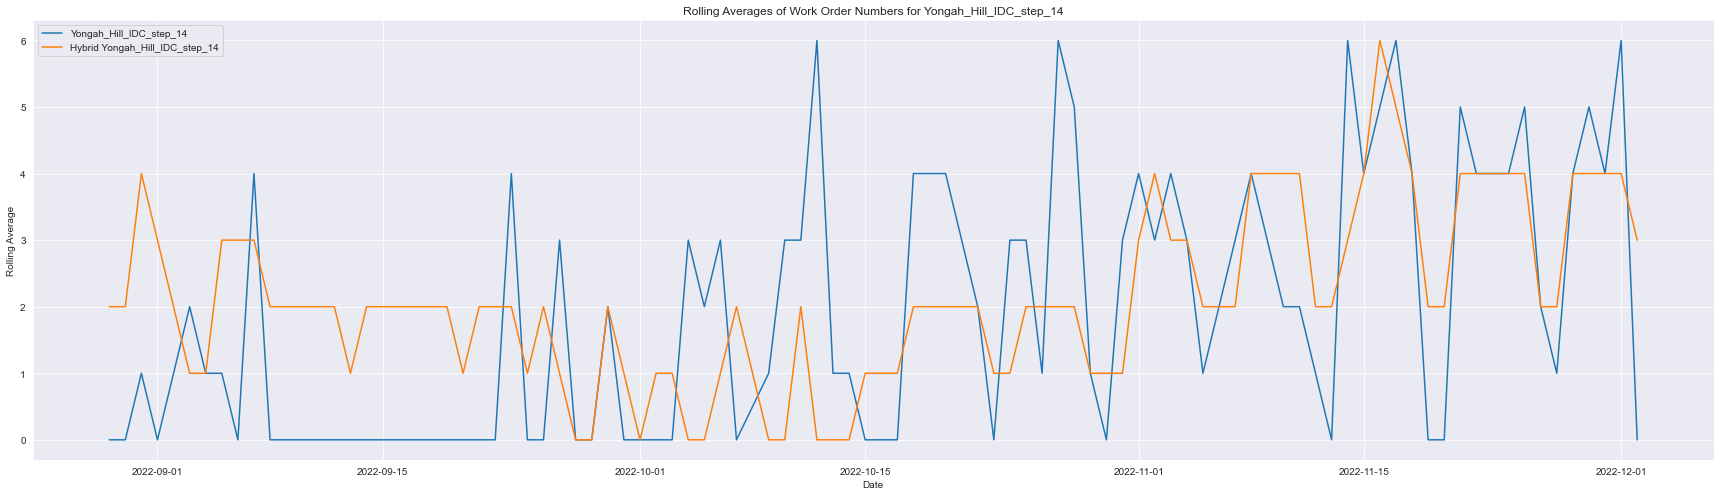

In [65]:
# Sort the DataFrame by index
X_test_hybrid.sort_index(inplace=True)

# Set the window size for rolling average
window_size = 1

for col in y_test.columns:
    if '14' in col:
        # Calculate rolling averages
        X_test_hybrid[f'{col}_Rolling_Avg'] = X_test_hybrid[f'{col}'].rolling(window=window_size).mean()
        X_test_hybrid[f'Hybrid{col}_Rolling_Avg'] = X_test_hybrid[f'Hybrid{col}'].rolling(window=window_size).mean()
        X_test_hybrid_grouped = X_test_hybrid[[f'{col}_Rolling_Avg', f'Hybrid{col}_Rolling_Avg']].groupby(X_test_hybrid.index).mean()

        # Create a line plot using Seaborn
        plt.figure(figsize=(24, 7))
        sns.lineplot(data=X_test_hybrid_grouped, x=X_test_hybrid_grouped.index, y=f'{col}_Rolling_Avg', label=f"{col}")
        sns.lineplot(data=X_test_hybrid_grouped, x=X_test_hybrid_grouped.index, y=f'Hybrid{col}_Rolling_Avg', label=f"Hybrid {col}")

        # Add a title to the graph
        plt.title(f"Rolling Averages of Work Order Numbers for {col}")
        plt.xlabel("Date")
        plt.ylabel("Rolling Average")
        plt.legend()
        plt.tight_layout()

        plt.show()

### Saving

In [67]:
import joblib

In [68]:
X_test_hybrid.to_csv('hybrid_data_split.csv')

# Save the trained LR model
lr_best_model.fit(X[lr_new_cols], y)
lr_model_filename = 'lr_model_split.pkl'
joblib.dump(lr_best_model, lr_model_filename)

# Save the trained XGBoost model
best_xgb_model.fit(X[xgb_new_cols], y)
xgb_model_filename = 'xgb_model_split.pkl'
joblib.dump(best_xgb_model, xgb_model_filename)

X[xgb_new_cols].to_csv('xgb_data_columns.csv')
X[lr_new_cols].to_csv('lr_data_columns.csv')